In [37]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

from scipy.stats import chi2_contingency
from scipy import stats
from scipy.stats import fisher_exact


import seaborn as sns
import matplotlib.pyplot as plt


# Load the three datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
app_data = pd.read_csv('data/app_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Perform a left join on 'patient_id' across the three datasets
merged_data = ab_test_data.merge(app_data, on='patient_id', how='left').merge(appointments_data, on='patient_id', how='left')

# Checking for missing values (NaNs) in all three dataframes

ab_test_na = ab_test_data.isna().sum()
app_data_na = app_data.isna().sum()
appointments_data_na = appointments_data.isna().sum()
merged_data_na = merged_data.isna().sum()
ab_test_na, app_data_na, appointments_data_na, merged_data_na


(patient_id        0
 group             0
 event_name        0
 event_datetime    0
 dtype: int64,
 patient_id        0
 traffic_source    0
 device            0
 dtype: int64,
 patient_id            0
 age                   0
 gender                0
 doctor_name           0
 appointment_reason    0
 appointment_date      0
 appointment_status    0
 dtype: int64,
 patient_id            0
 group                 0
 event_name            0
 event_datetime        0
 traffic_source        0
 device                0
 age                   0
 gender                0
 doctor_name           0
 appointment_reason    0
 appointment_date      0
 appointment_status    0
 dtype: int64)

In [2]:
# Inspect data
print(appointments_data.info())
print(ab_test_data.info())
print(app_data.info())

# Check for missing values
print(appointments_data.isnull().sum())
print(ab_test_data.isnull().sum())
print(app_data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2678 entries, 0 to 2677
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   patient_id          2678 non-null   int64 
 1   age                 2678 non-null   int64 
 2   gender              2678 non-null   object
 3   doctor_name         2678 non-null   object
 4   appointment_reason  2678 non-null   object
 5   appointment_date    2678 non-null   object
 6   appointment_status  2678 non-null   object
dtypes: int64(2), object(5)
memory usage: 146.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5660 entries, 0 to 5659
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   patient_id      5660 non-null   int64 
 1   group           5660 non-null   object
 2   event_name      5660 non-null   object
 3   event_datetime  5660 non-null   object
dtypes: int64(1), object(3)
memory 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       381
           1       0.78      1.00      0.87      1317

    accuracy                           0.78      1698
   macro avg       0.39      0.50      0.44      1698
weighted avg       0.60      0.78      0.68      1698



/Users/ismatsamadov/kyla_ProductAnalyst/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ismatsamadov/kyla_ProductAnalyst/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ismatsamadov/kyla_ProductAnalyst/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

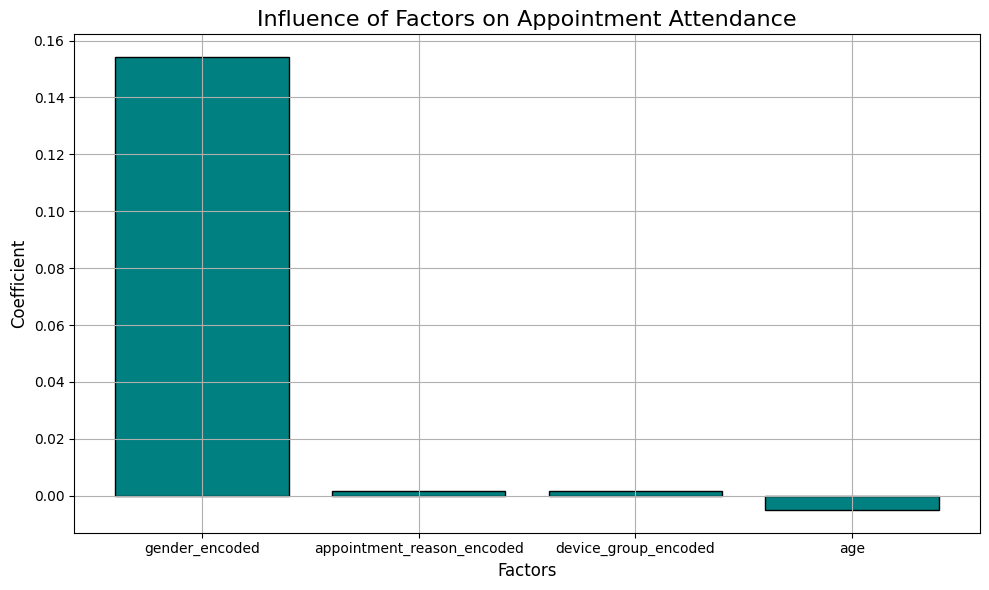

                       Factor  Coefficient
1              gender_encoded     0.154240
2  appointment_reason_encoded     0.001515
3        device_group_encoded     0.001509
0                         age    -0.005010


In [3]:

# Load the datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Merge the datasets on patient_id
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Encode categorical variables (e.g., gender, appointment reason, device group)
le_gender = LabelEncoder()
merged_data['gender_encoded'] = le_gender.fit_transform(merged_data['gender'])

le_appointment_reason = LabelEncoder()
merged_data['appointment_reason_encoded'] = le_appointment_reason.fit_transform(merged_data['appointment_reason'])

le_device_group = LabelEncoder()
merged_data['device_group_encoded'] = le_device_group.fit_transform(merged_data['device'])

# Create a feature matrix X and target vector y
X = merged_data[['age', 'gender_encoded', 'appointment_reason_encoded', 'device_group_encoded']]
y = merged_data['appointment_status'].apply(lambda x: 1 if x == 'Attended' else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Display a classification report
print(classification_report(y_test, y_pred))

# Display the coefficients to interpret the influence of factors
coefficients = pd.DataFrame({"Factor": X.columns, "Coefficient": model.coef_[0]})
coefficients.sort_values(by="Coefficient", ascending=False, inplace=True)

# Plot the coefficients for each factor
plt.figure(figsize=(10, 6))
plt.bar(coefficients['Factor'], coefficients['Coefficient'], color='teal', edgecolor='black')
plt.title('Influence of Factors on Appointment Attendance', fontsize=16)
plt.xlabel('Factors', fontsize=12)
plt.ylabel('Coefficient', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the sorted coefficients for further interpretation
print(coefficients)


Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.59      0.61       381
           1       0.88      0.90      0.89      1317

    accuracy                           0.83      1698
   macro avg       0.76      0.75      0.75      1698
weighted avg       0.83      0.83      0.83      1698

Accuracy Score:  0.8303886925795053


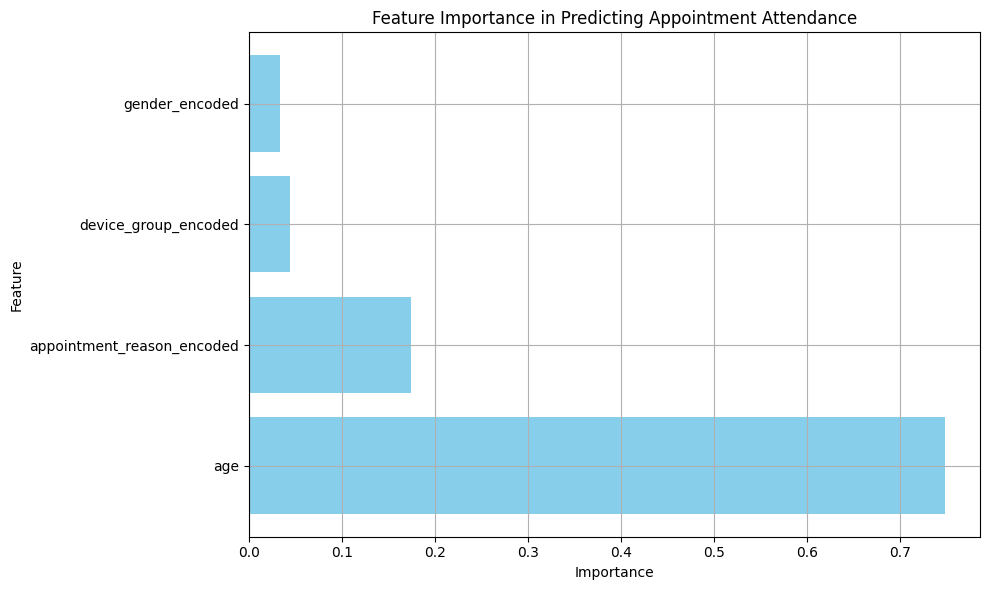

In [4]:
# Reload the necessary data
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Merge the datasets
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Group devices into Android, iOS, and Other
merged_data['device_group'] = merged_data['device'].str.lower().apply(lambda x: 'android' if 'android' in x else ('ios' if 'ios' in x else 'other'))

# Encode categorical variables (gender, appointment reason, device group)
le_gender = LabelEncoder()
merged_data['gender_encoded'] = le_gender.fit_transform(merged_data['gender'])

le_appointment_reason = LabelEncoder()
merged_data['appointment_reason_encoded'] = le_appointment_reason.fit_transform(merged_data['appointment_reason'])

le_device_group = LabelEncoder()
merged_data['device_group_encoded'] = le_device_group.fit_transform(merged_data['device_group'])

# Create the feature matrix X and target vector y
X = merged_data[['age', 'gender_encoded', 'appointment_reason_encoded', 'device_group_encoded']]
y = merged_data['appointment_status'].apply(lambda x: 1 if x == 'Attended' else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Display a classification report
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

# Get feature importance from the model
feature_importance = rf_model.feature_importances_

# Create a DataFrame to visualize feature importance
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Feature Importance in Predicting Appointment Attendance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()


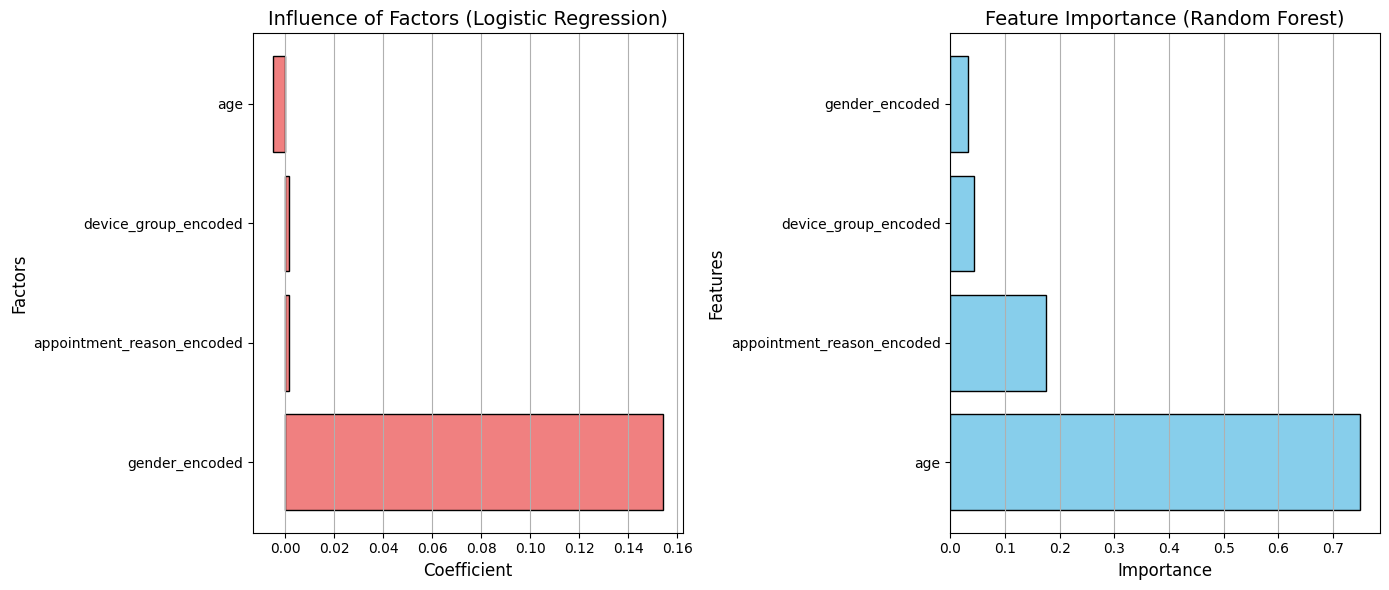

In [5]:
# Plot the logistic regression coefficients
plt.figure(figsize=(14, 6))

# Subplot 1: Logistic Regression Coefficients
plt.subplot(1, 2, 1)
plt.barh(coefficients['Factor'], coefficients['Coefficient'], color='lightcoral', edgecolor='black')
plt.title('Influence of Factors (Logistic Regression)', fontsize=14)
plt.xlabel('Coefficient', fontsize=12)
plt.ylabel('Factors', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, axis='x')

# Subplot 2: Random Forest Feature Importance
plt.subplot(1, 2, 2)
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue', edgecolor='black')
plt.title('Feature Importance (Random Forest)', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, axis='x')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


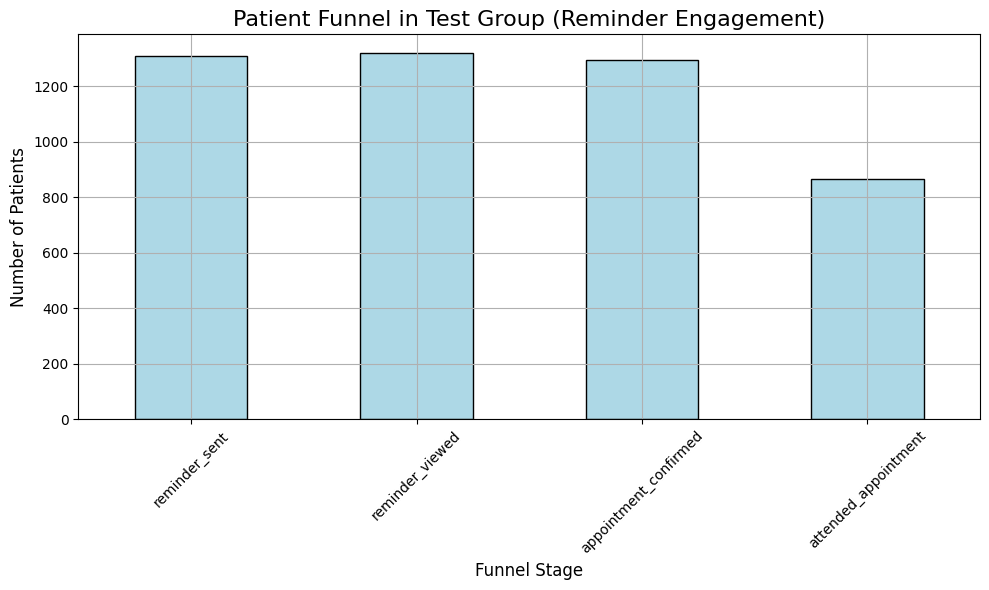

In [6]:

# Merge the data on patient_id
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Filter for Test group
test_group = merged_data[merged_data['group'] == 'Test']

# Calculate how many patients went through each funnel stage
funnel_counts = test_group['event_name'].value_counts()

# Creating the funnel stages order
funnel_order = ['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment']
funnel_counts = funnel_counts.reindex(funnel_order).fillna(0)

# Plotting the funnel
plt.figure(figsize=(10, 6))
funnel_counts.plot(kind='bar', color='lightblue', edgecolor='black')

# Adding titles and labels
plt.title('Patient Funnel in Test Group (Reminder Engagement)', fontsize=16)
plt.xlabel('Funnel Stage', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


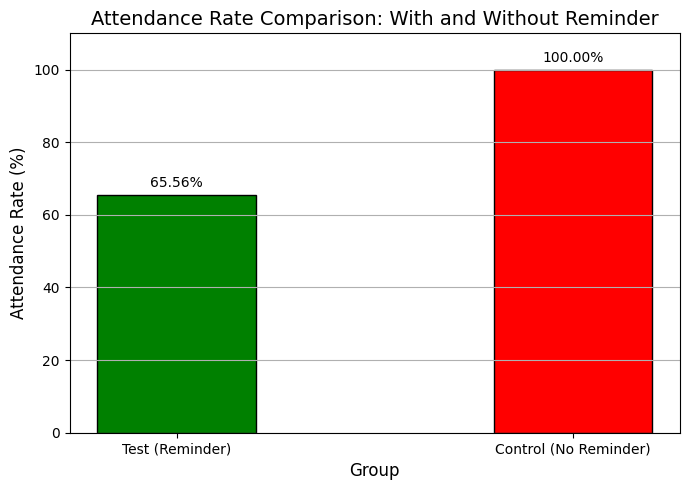

Test Group (With Reminder) Attendance Rate: 65.56%
Control Group (Without Reminder) Attendance Rate: 100.00%


In [7]:

# Merge the data on patient_id
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Filter for Test and Control groups
test_group = merged_data[merged_data['group'] == 'Test']
control_group = merged_data[merged_data['group'] == 'Control']

# Calculate attendance rates for Test group (Reminder sent)
test_attended = test_group[test_group['appointment_status'] == 'Attended']['patient_id'].nunique()
test_total = test_group['patient_id'].nunique()
test_attendance_rate = (test_attended / test_total) * 100

# Calculate attendance rates for Control group (No reminder)
control_attended = control_group[control_group['appointment_status'] == 'Attended']['patient_id'].nunique()
control_total = control_group['patient_id'].nunique()
control_attendance_rate = (control_attended / control_total) * 100

# Create a DataFrame to store the attendance rates for both groups
attendance_data = pd.DataFrame({
    'Group': ['Test (Reminder)', 'Control (No Reminder)'],
    'Attendance Rate (%)': [test_attendance_rate, control_attendance_rate]
})

# Plot the attendance rates comparison
plt.figure(figsize=(7, 5))
plt.bar(attendance_data['Group'], attendance_data['Attendance Rate (%)'], color=['green', 'red'], edgecolor='black', width=0.4)

# Add titles and labels with reasonable fonts
plt.title('Attendance Rate Comparison: With and Without Reminder', fontsize=14)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Attendance Rate (%)', fontsize=12)
plt.ylim(0, 110)  # Adjust the limit to fit 100% for control
plt.grid(True, axis='y')

# Display the attendance rate for each group on the bars
for i, rate in enumerate(attendance_data['Attendance Rate (%)']):
    plt.text(i, rate + 2, f'{rate:.2f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Print out the calculated rates
print(f"Test Group (With Reminder) Attendance Rate: {test_attendance_rate:.2f}%")
print(f"Control Group (Without Reminder) Attendance Rate: {control_attendance_rate:.2f}%")


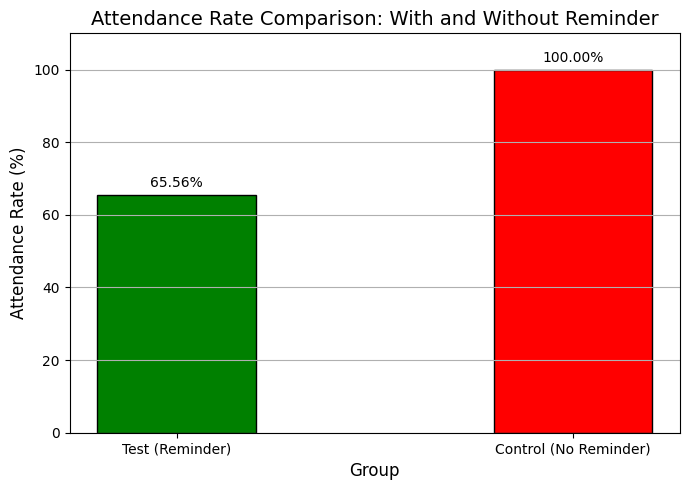

Test Group (With Reminder) Attendance Rate: 65.56%
Control Group (Without Reminder) Attendance Rate: 100.00%


In [8]:

# Merge the data on patient_id
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Filter for Test and Control groups
test_group = merged_data[merged_data['group'] == 'Test']
control_group = merged_data[merged_data['group'] == 'Control']

# Calculate attendance rates for Test group (Reminder sent)
test_attended = test_group[test_group['appointment_status'] == 'Attended']['patient_id'].nunique()
test_total = test_group['patient_id'].nunique()
test_attendance_rate = (test_attended / test_total) * 100

# Calculate attendance rates for Control group (No reminder)
control_attended = control_group[control_group['appointment_status'] == 'Attended']['patient_id'].nunique()
control_total = control_group['patient_id'].nunique()
control_attendance_rate = (control_attended / control_total) * 100

# Create a DataFrame to store the attendance rates for both groups
attendance_data = pd.DataFrame({
    'Group': ['Test (Reminder)', 'Control (No Reminder)'],
    'Attendance Rate (%)': [test_attendance_rate, control_attendance_rate]
})

# Plot the attendance rates comparison
plt.figure(figsize=(7, 5))
plt.bar(attendance_data['Group'], attendance_data['Attendance Rate (%)'], color=['green', 'red'], edgecolor='black', width=0.4)

# Add titles and labels with reasonable fonts
plt.title('Attendance Rate Comparison: With and Without Reminder', fontsize=14)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Attendance Rate (%)', fontsize=12)
plt.ylim(0, 110)  # Adjust the limit to fit 100% for control
plt.grid(True, axis='y')

# Display the attendance rate for each group on the bars
for i, rate in enumerate(attendance_data['Attendance Rate (%)']):
    plt.text(i, rate + 2, f'{rate:.2f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Print out the calculated rates
print(f"Test Group (With Reminder) Attendance Rate: {test_attendance_rate:.2f}%")
print(f"Control Group (Without Reminder) Attendance Rate: {control_attendance_rate:.2f}%")


Test Group Appointment Status Distribution:
appointment_status
Attended        3457
Not Attended    1334
Name: count, dtype: int64

Control Group Appointment Status Distribution:
appointment_status
Attended    869
Name: count, dtype: int64

Test Group (With Reminder) Attendance Rate: 866/1321 (65.56%)
Control Group (Without Reminder) Attendance Rate: 869/869 (100.00%)


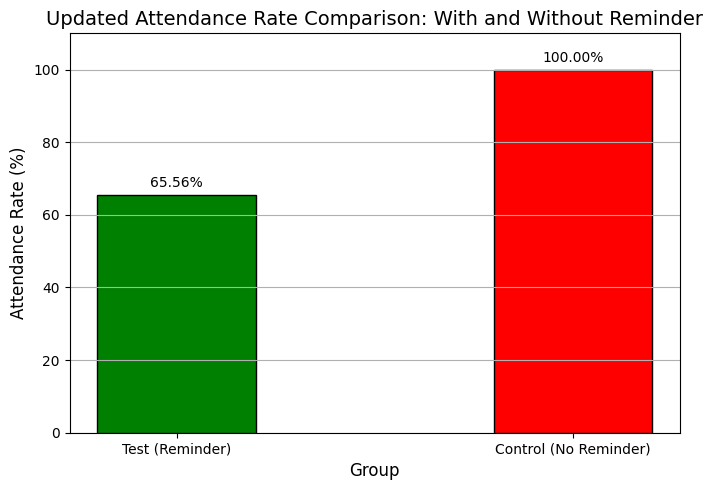

In [9]:
# Step 1: Inspect the appointment_status distribution in both Test and Control groups
test_appointment_status_dist = test_group['appointment_status'].value_counts()
control_appointment_status_dist = control_group['appointment_status'].value_counts()

print("Test Group Appointment Status Distribution:")
print(test_appointment_status_dist)

print("\nControl Group Appointment Status Distribution:")
print(control_appointment_status_dist)

# Step 2: Double check attendance rates with more transparency
test_attended = test_group[test_group['appointment_status'] == 'Attended']['patient_id'].nunique()
test_total = test_group['patient_id'].nunique()
test_attendance_rate = (test_attended / test_total) * 100

control_attended = control_group[control_group['appointment_status'] == 'Attended']['patient_id'].nunique()
control_total = control_group['patient_id'].nunique()
control_attendance_rate = (control_attended / control_total) * 100

print(f"\nTest Group (With Reminder) Attendance Rate: {test_attended}/{test_total} ({test_attendance_rate:.2f}%)")
print(f"Control Group (Without Reminder) Attendance Rate: {control_attended}/{control_total} ({control_attendance_rate:.2f}%)")

# Step 3: Check for potential patterns in the Control group that might lead to 100% attendance
# If the Control Group really has 100%, investigate why.

# Visualize the attendance distribution for each group again if necessary
attendance_data = pd.DataFrame({
    'Group': ['Test (Reminder)', 'Control (No Reminder)'],
    'Attendance Rate (%)': [test_attendance_rate, control_attendance_rate]
})

# Plot the updated attendance rates comparison
plt.figure(figsize=(7, 5))
plt.bar(attendance_data['Group'], attendance_data['Attendance Rate (%)'], color=['green', 'red'], edgecolor='black', width=0.4)
plt.title('Updated Attendance Rate Comparison: With and Without Reminder', fontsize=14)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Attendance Rate (%)', fontsize=12)
plt.ylim(0, 110)
plt.grid(True, axis='y')

# Annotate the bars
for i, rate in enumerate(attendance_data['Attendance Rate (%)']):
    plt.text(i, rate + 2, f'{rate:.2f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


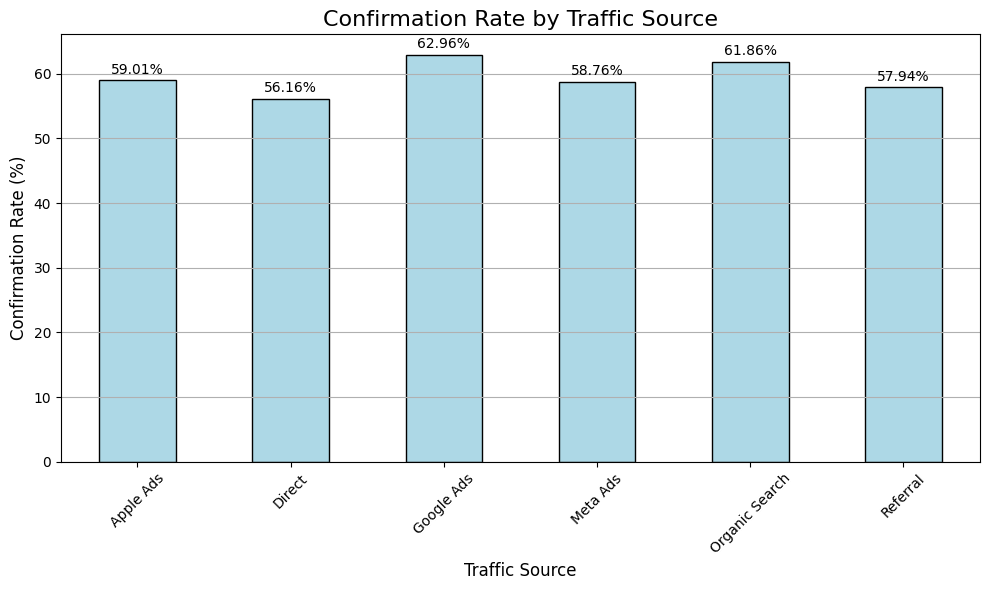

traffic_source
Apple Ads         59.006211
Direct            56.156716
Google Ads        62.962963
Meta Ads          58.757062
Organic Search    61.859583
Referral          57.940663
Name: patient_id, dtype: float64


In [10]:

# Merge the datasets on patient_id
merged_data = pd.merge(pd.merge(ab_test_data, appointments_data, on='patient_id', how='left'), app_data, on='patient_id', how='left')

# Filter for confirmed appointments
confirmed_appointments = merged_data[merged_data['event_name'] == 'appointment_confirmed']

# Calculate the number of confirmed appointments by traffic source
confirmed_by_traffic_source = confirmed_appointments.groupby('traffic_source')['patient_id'].nunique()

# Calculate the total number of patients by traffic source
total_by_traffic_source = merged_data.groupby('traffic_source')['patient_id'].nunique()

# Calculate confirmation rate by traffic source
confirmation_rate_by_traffic_source = (confirmed_by_traffic_source / total_by_traffic_source) * 100

# Plot the confirmation rates by traffic source
plt.figure(figsize=(10, 6))
confirmation_rate_by_traffic_source.plot(kind='bar', color='lightblue', edgecolor='black')

# Add titles and labels
plt.title('Confirmation Rate by Traffic Source', fontsize=16)
plt.xlabel('Traffic Source', fontsize=12)
plt.ylabel('Confirmation Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, axis='y')

# Display the confirmation rate for each traffic source on the bars
for i, rate in enumerate(confirmation_rate_by_traffic_source):
    plt.text(i, rate + 1, f'{rate:.2f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Print the confirmation rates by traffic source
print(confirmation_rate_by_traffic_source)


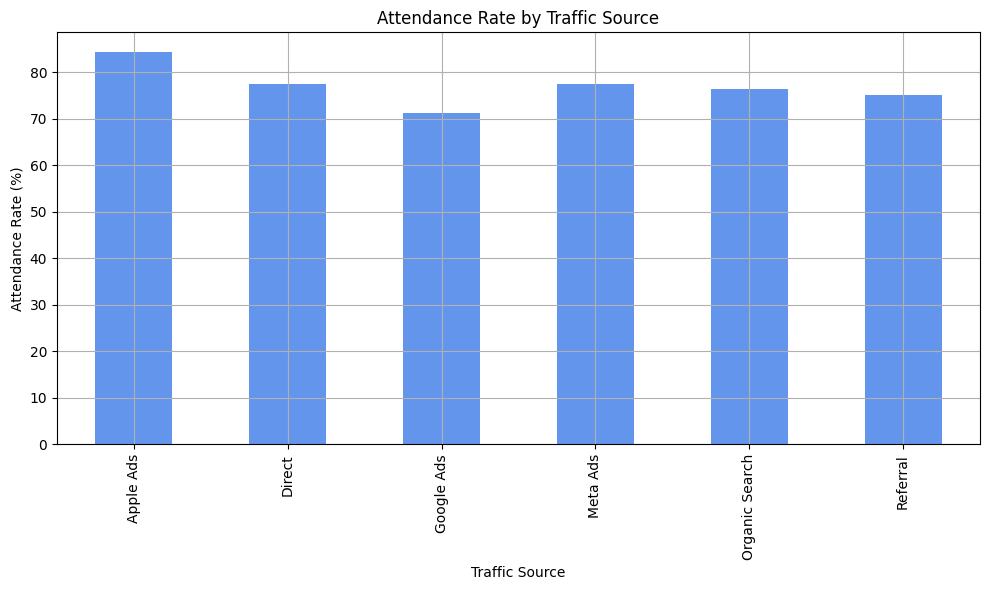

In [11]:

# Ensure that the merged data includes traffic_source and appointment_status
# Group by traffic_source and calculate the attendance rate
traffic_source_attendance = merged_data.groupby('traffic_source')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)['Attended'] * 100

# Visualize attendance rate by traffic source
plt.figure(figsize=(10, 6))
traffic_source_attendance.plot(kind='bar', color='cornflowerblue')
plt.title('Attendance Rate by Traffic Source')
plt.xlabel('Traffic Source')
plt.ylabel('Attendance Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


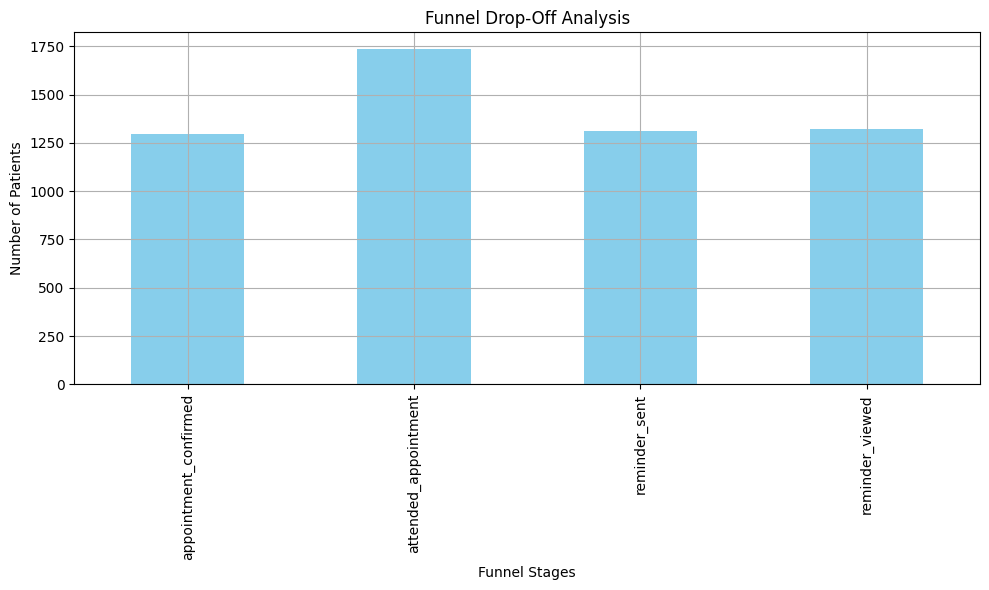

In [12]:
# Funnel stages drop-off rates
funnel_stages = ['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment']
funnel_counts = merged_data[merged_data['event_name'].isin(funnel_stages)].groupby('event_name')['patient_id'].nunique()

# Plot the funnel analysis
plt.figure(figsize=(10, 6))
funnel_counts.plot(kind='bar', color='skyblue')
plt.title('Funnel Drop-Off Analysis')
plt.xlabel('Funnel Stages')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_9309/1406951011.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_dropoff = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('age_group')['patient_id'].nunique()
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_9309/1406951011.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_age_group = merged_data.groupby('age_group')['patient_id'].nunique()


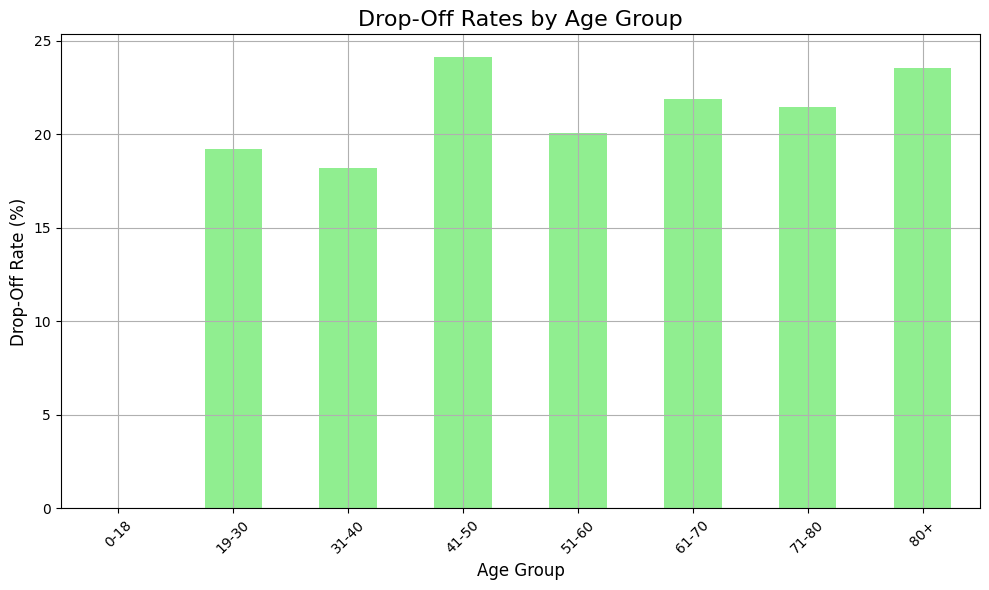

In [15]:

# Reload the necessary data
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Merge the datasets
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Group devices into Android, iOS, and Other
merged_data['device_group'] = merged_data['device'].str.lower().apply(lambda x: 'android' if 'android' in x else ('ios' if 'ios' in x else 'other'))

# Create age groups
bins = [0, 18, 30, 40, 50, 60, 70, 80, 100]
labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-80', '80+']
merged_data['age_group'] = pd.cut(merged_data['age'], bins=bins, labels=labels, right=False)

# Drop-off rates by age group
age_group_dropoff = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('age_group')['patient_id'].nunique()
total_age_group = merged_data.groupby('age_group')['patient_id'].nunique()
dropoff_rate_age = (age_group_dropoff / total_age_group) * 100

# Plot drop-off by age group
plt.figure(figsize=(10, 6))
dropoff_rate_age.plot(kind='bar', color='lightgreen')
plt.title('Drop-Off Rates by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Drop-Off Rate (%)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


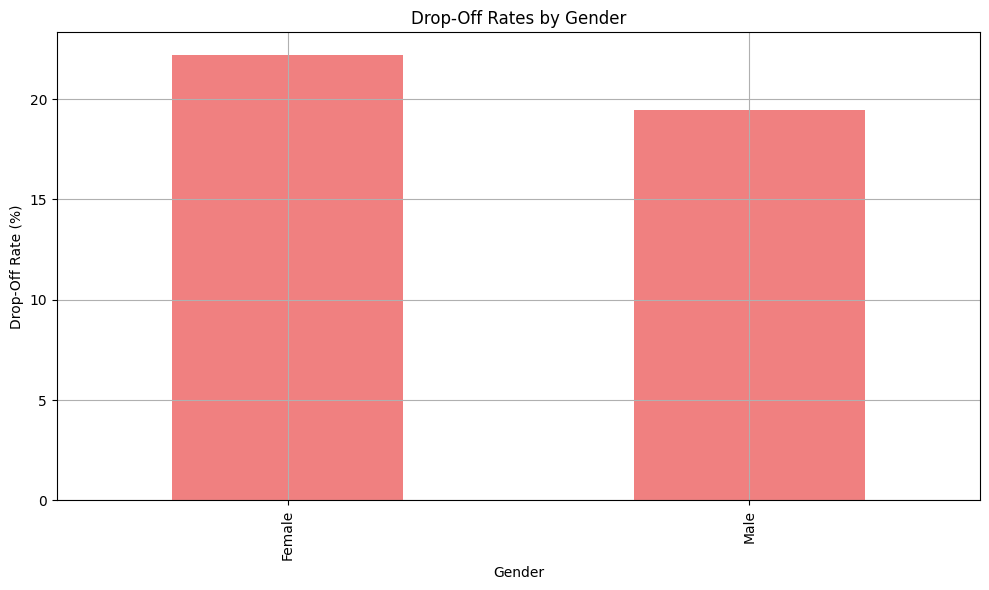

In [45]:
# Drop-off rates by gender
gender_dropoff = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('gender')['patient_id'].nunique()
total_gender = merged_data.groupby('gender')['patient_id'].nunique()
dropoff_rate_gender = (gender_dropoff / total_gender) * 100

# Plot drop-off by gender
plt.figure(figsize=(10, 6))
dropoff_rate_gender.plot(kind='bar', color='lightcoral')
plt.title('Drop-Off Rates by Gender')
plt.xlabel('Gender')
plt.ylabel('Drop-Off Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


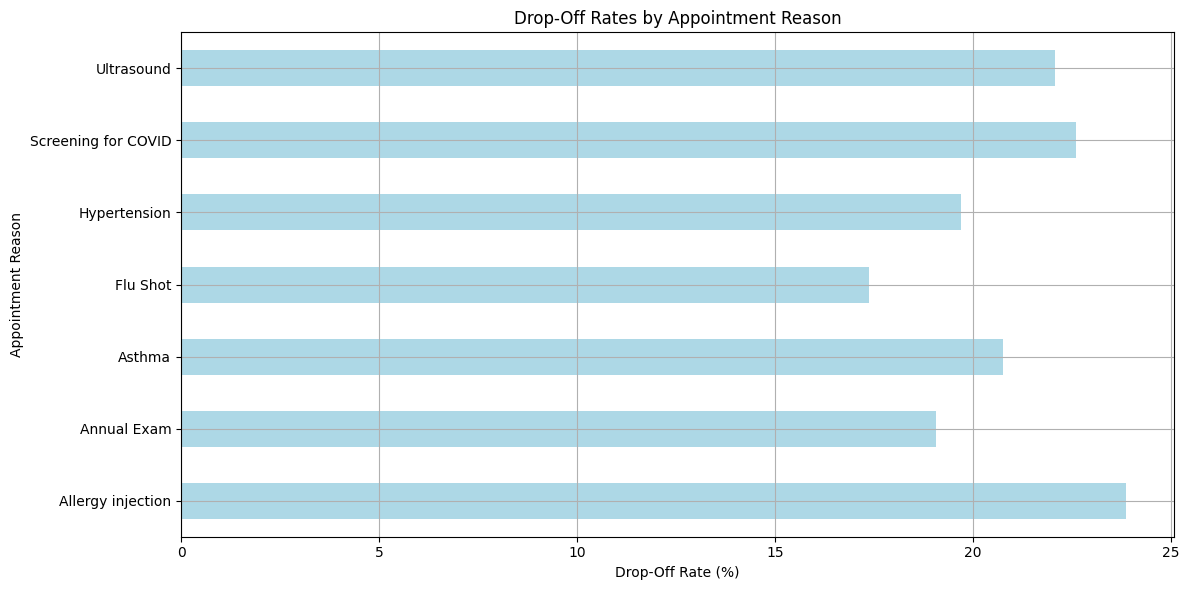

In [46]:
# Drop-off rates by appointment reason
reason_dropoff = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('appointment_reason')['patient_id'].nunique()
total_reason = merged_data.groupby('appointment_reason')['patient_id'].nunique()
dropoff_rate_reason = (reason_dropoff / total_reason) * 100

# Plot drop-off by appointment reason
plt.figure(figsize=(12, 6))
dropoff_rate_reason.plot(kind='barh', color='lightblue')
plt.title('Drop-Off Rates by Appointment Reason')
plt.xlabel('Drop-Off Rate (%)')
plt.ylabel('Appointment Reason')
plt.grid(True)
plt.tight_layout()
plt.show()


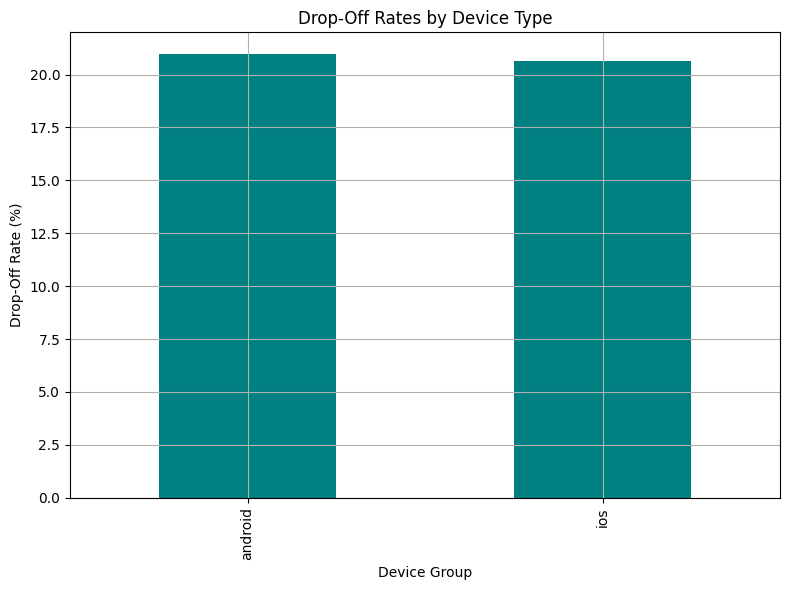

In [47]:
# Drop-off rates by device type
device_group_dropoff = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('device_group')['patient_id'].nunique()
total_device_group = merged_data.groupby('device_group')['patient_id'].nunique()
dropoff_rate_device = (device_group_dropoff / total_device_group) * 100

# Plot drop-off by device group
plt.figure(figsize=(8, 6))
dropoff_rate_device.plot(kind='bar', color='teal')
plt.title('Drop-Off Rates by Device Type')
plt.xlabel('Device Group')
plt.ylabel('Drop-Off Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


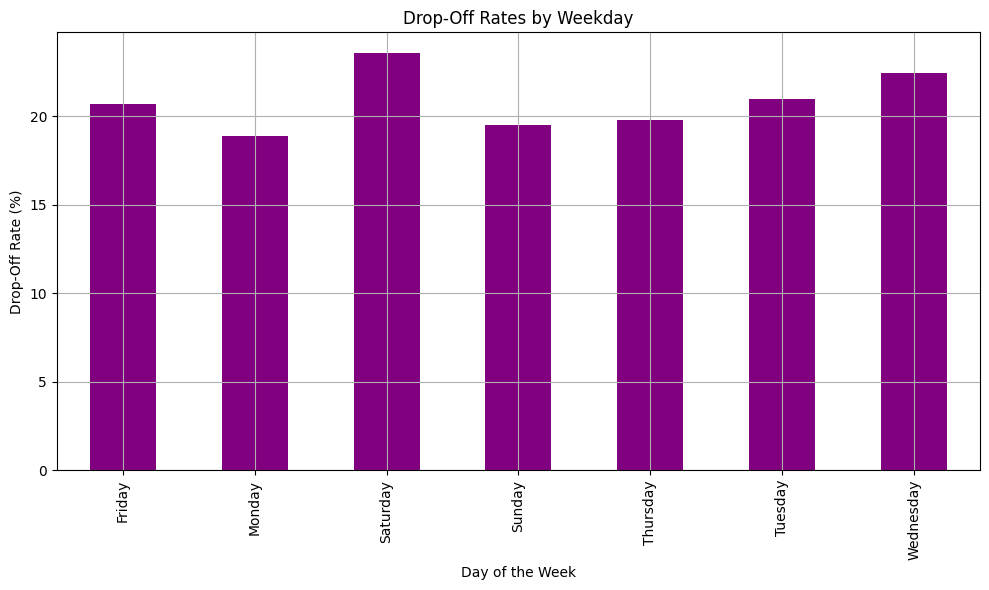

In [48]:
# Drop-off rates by day of the week
merged_data['weekday'] = pd.to_datetime(merged_data['appointment_date']).dt.day_name()
weekday_dropoff = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('weekday')['patient_id'].nunique()
total_weekday = merged_data.groupby('weekday')['patient_id'].nunique()
dropoff_rate_weekday = (weekday_dropoff / total_weekday) * 100

# Plot drop-off by weekday
plt.figure(figsize=(10, 6))
dropoff_rate_weekday.plot(kind='bar', color='purple')
plt.title('Drop-Off Rates by Weekday')
plt.xlabel('Day of the Week')
plt.ylabel('Drop-Off Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


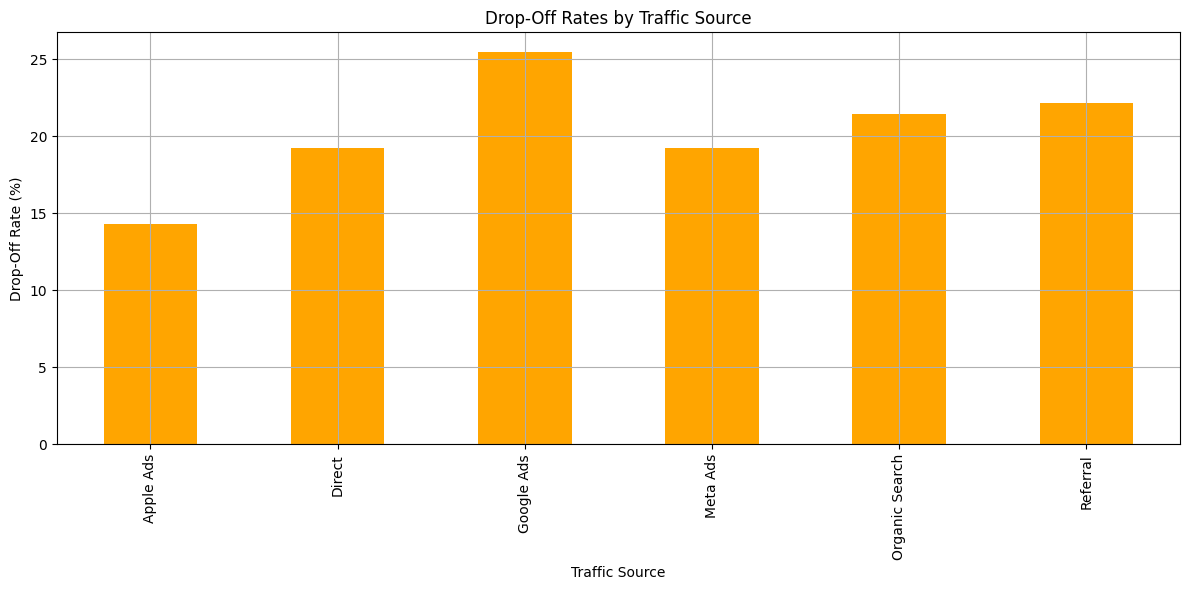

In [49]:
# Drop-off rates by traffic source
traffic_source_dropoff = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('traffic_source')['patient_id'].nunique()
total_traffic_source = merged_data.groupby('traffic_source')['patient_id'].nunique()
dropoff_rate_traffic = (traffic_source_dropoff / total_traffic_source) * 100

# Plot drop-off by traffic source
plt.figure(figsize=(12, 6))
dropoff_rate_traffic.plot(kind='bar', color='orange')
plt.title('Drop-Off Rates by Traffic Source')
plt.xlabel('Traffic Source')
plt.ylabel('Drop-Off Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


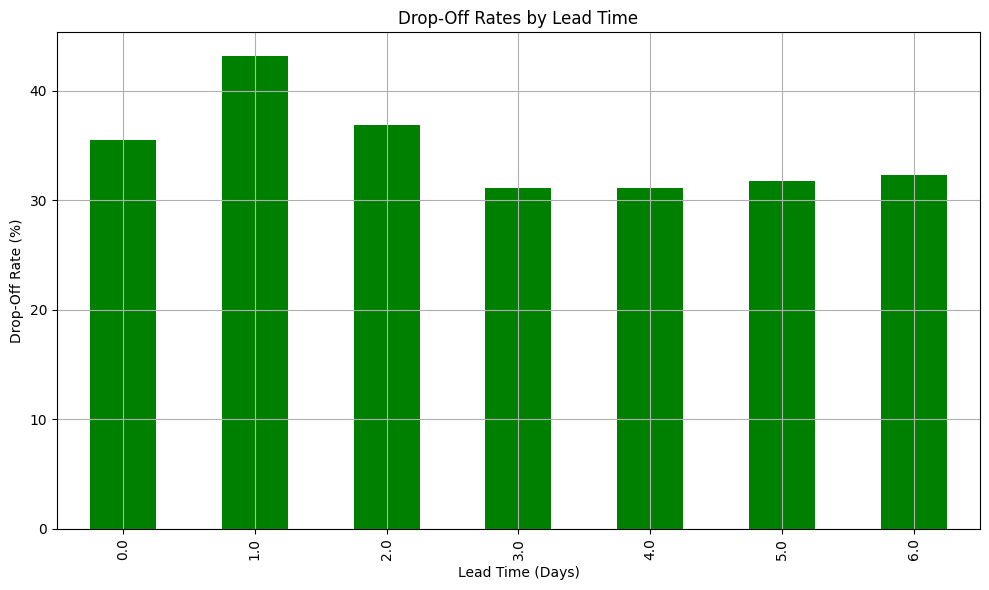

In [54]:
# Convert the necessary columns to datetime
appointments_data['appointment_date'] = pd.to_datetime(appointments_data['appointment_date'])
ab_test_data['event_datetime'] = pd.to_datetime(ab_test_data['event_datetime'])

# Extract reminder_sent and appointment_confirmed from ab_test_data
reminder_sent_data = ab_test_data[ab_test_data['event_name'] == 'reminder_sent'][['patient_id', 'event_datetime']].rename(columns={'event_datetime': 'reminder_sent_datetime'})
appointment_confirmed_data = ab_test_data[ab_test_data['event_name'] == 'appointment_confirmed'][['patient_id', 'event_datetime']].rename(columns={'event_datetime': 'appointment_confirmed_datetime'})

# Merge the reminder and confirmed data into appointments_data
merged_data = pd.merge(appointments_data, reminder_sent_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, appointment_confirmed_data, on='patient_id', how='left')

# Calculate the lead time (in days) between reminder_sent and appointment_date
merged_data['lead_time'] = (merged_data['appointment_date'] - merged_data['reminder_sent_datetime']).dt.days
merged_data['lead_time'] = merged_data['lead_time'].clip(lower=0)

# Drop-off rates by lead time
lead_time_dropoff = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('lead_time')['patient_id'].nunique()
total_lead_time = merged_data.groupby('lead_time')['patient_id'].nunique()
dropoff_rate_lead_time = (lead_time_dropoff / total_lead_time) * 100

# Plot drop-off by lead time
plt.figure(figsize=(10, 6))
dropoff_rate_lead_time.plot(kind='bar', color='green')
plt.title('Drop-Off Rates by Lead Time')
plt.xlabel('Lead Time (Days)')
plt.ylabel('Drop-Off Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

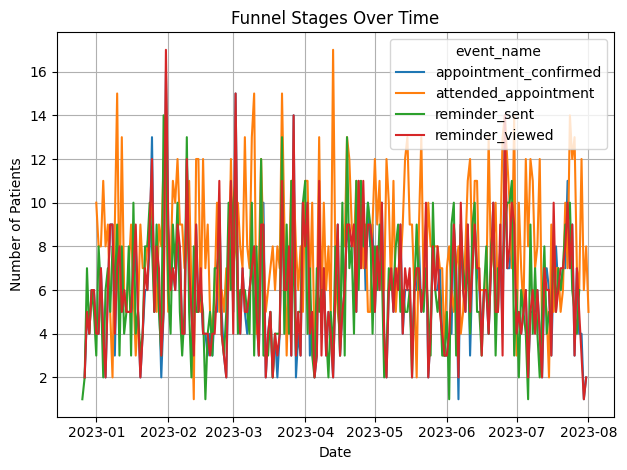

In [51]:
# Funnel stages over time
merged_data['event_datetime'] = pd.to_datetime(merged_data['event_datetime'])
funnel_time = merged_data[merged_data['event_name'].isin(funnel_stages)].groupby([merged_data['event_datetime'].dt.date, 'event_name'])['patient_id'].nunique().unstack()

# Plot funnel stages over time
plt.figure(figsize=(12, 6))
funnel_time.plot(kind='line')
plt.title('Funnel Stages Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.tight_layout()
plt.show()


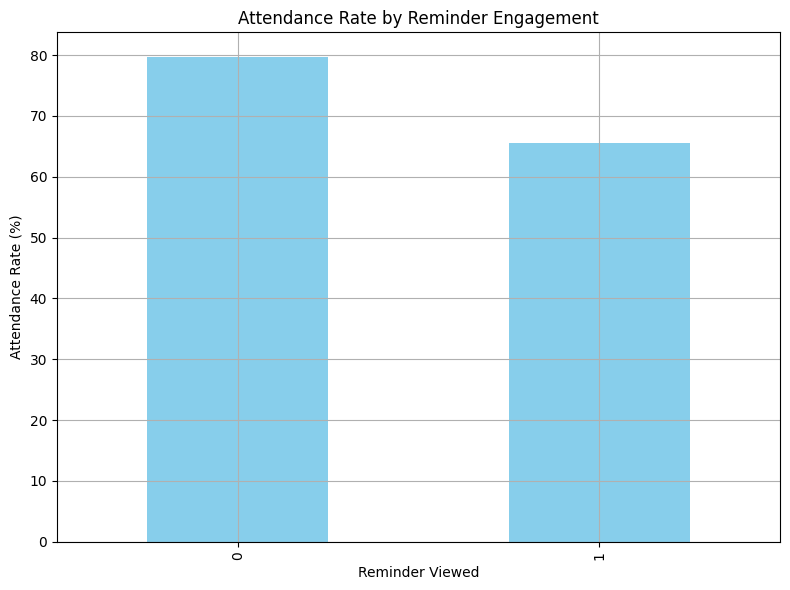

In [52]:
# Reminder engagement and attendance rates
reminder_viewed_attendance = merged_data.groupby('reminder_viewed')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)['Attended'] * 100

# Plot reminder engagement and attendance
plt.figure(figsize=(8, 6))
reminder_viewed_attendance.plot(kind='bar', color='skyblue')
plt.title('Attendance Rate by Reminder Engagement')
plt.xlabel('Reminder Viewed')
plt.ylabel('Attendance Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_5882/3362975932.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_attendance = merged_data.groupby('age_group')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)['Attended'] * 100


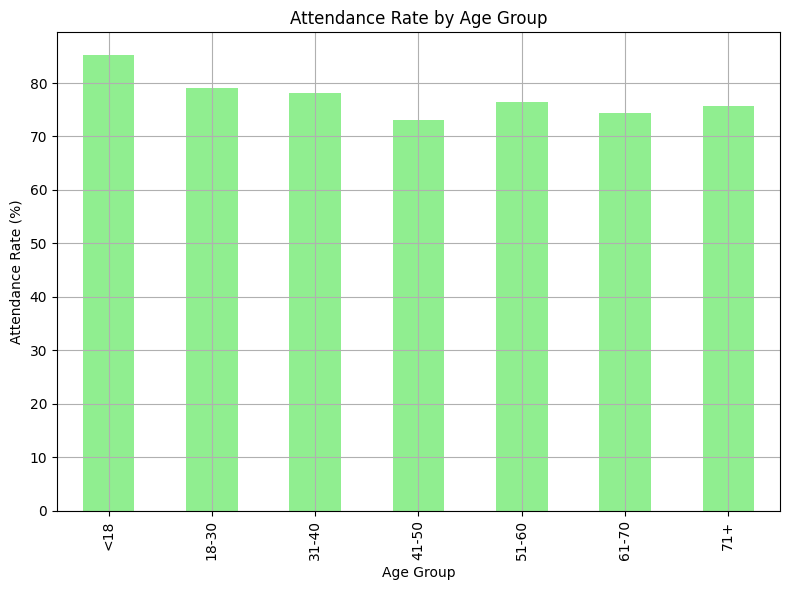

In [35]:
# Create age groups
merged_data['age_group'] = pd.cut(merged_data['age'], bins=[0, 18, 30, 40, 50, 60, 70, 100], labels=['<18', '18-30', '31-40', '41-50', '51-60', '61-70', '71+'])

# Group by age group and calculate attendance rate
age_group_attendance = merged_data.groupby('age_group')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)['Attended'] * 100

# Visualize attendance by age group
plt.figure(figsize=(8, 6))
age_group_attendance.plot(kind='bar', color='lightgreen')
plt.title('Attendance Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Attendance Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


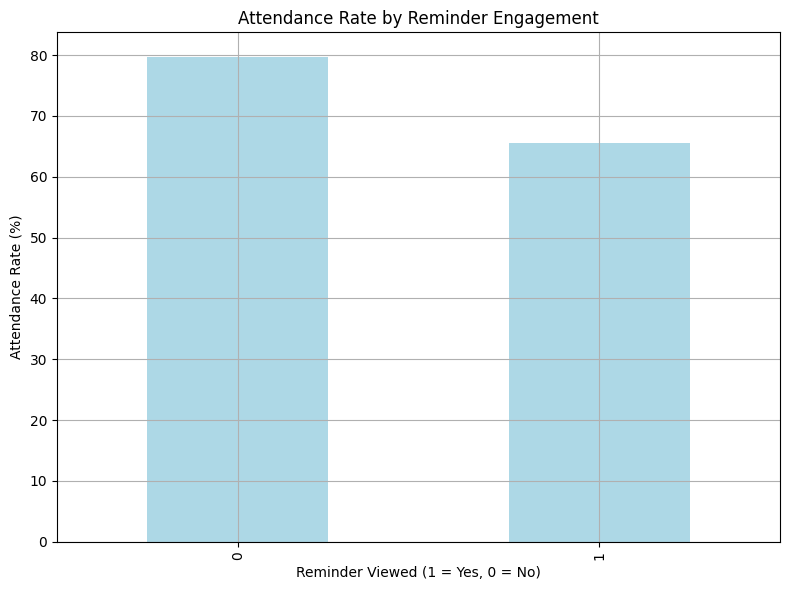

In [36]:
# Create a binary column 'reminder_viewed' based on event_name
merged_data['reminder_viewed'] = merged_data['event_name'].apply(lambda x: 1 if x == 'reminder_viewed' else 0)

# Group by reminder_viewed and calculate attendance rate
reminder_attendance = merged_data.groupby('reminder_viewed')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)['Attended'] * 100

# Visualize attendance by reminder engagement
plt.figure(figsize=(8, 6))
reminder_attendance.plot(kind='bar', color='lightblue')
plt.title('Attendance Rate by Reminder Engagement')
plt.xlabel('Reminder Viewed (1 = Yes, 0 = No)')
plt.ylabel('Attendance Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


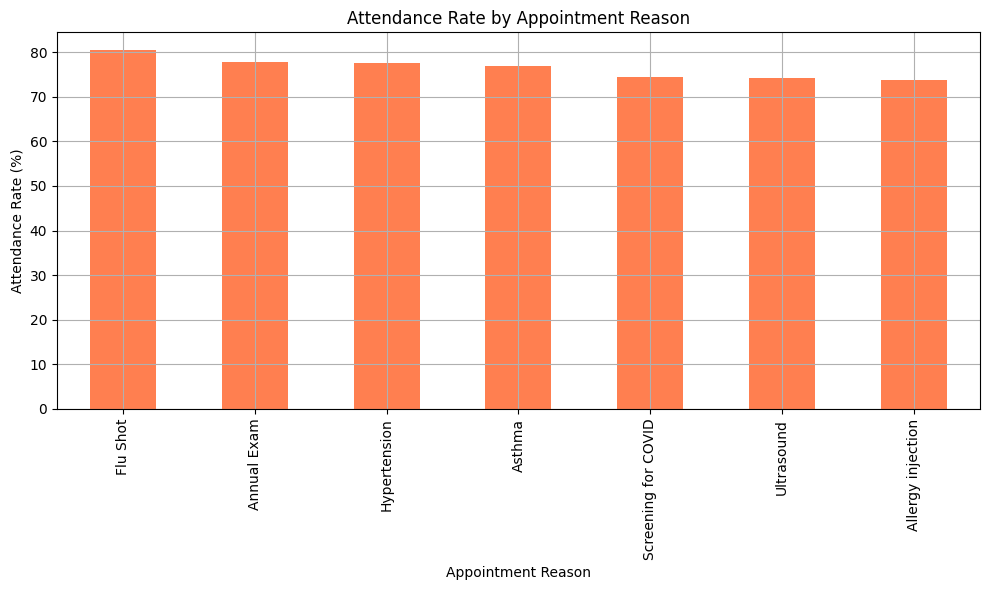

In [34]:
# Group by appointment_reason and calculate attendance rate
reason_attendance = merged_data.groupby('appointment_reason')['appointment_status'].value_counts(normalize=True).unstack().fillna(0)['Attended'] * 100

# Visualize attendance by appointment reason
plt.figure(figsize=(10, 6))
reason_attendance.sort_values(ascending=False).plot(kind='bar', color='coral')
plt.title('Attendance Rate by Appointment Reason')
plt.xlabel('Appointment Reason')
plt.ylabel('Attendance Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


      patient_id  time_to_confirm
0              2        19.123056
1              3        15.434167
2              7        23.312222
3              9        10.961944
4             12        29.717500
...          ...              ...
1279        2659         3.248333
1280        2661        23.098333
1281        2663         4.670278
1282        2666         7.453889
1283        2670        13.495833

[1284 rows x 2 columns]


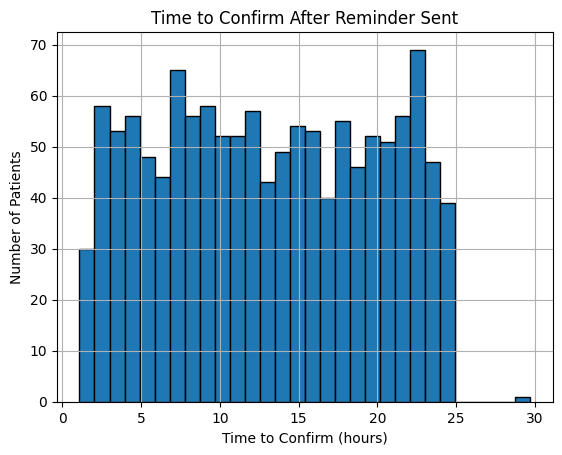

In [6]:

# Step 1: Filter for the Test group
test_group = ab_test_data[ab_test_data['group'] == 'Test']

# Step 2: Extract 'reminder_sent' and 'appointment_confirmed' events
reminder_sent = test_group[test_group['event_name'] == 'reminder_sent']
appointment_confirmed = test_group[test_group['event_name'] == 'appointment_confirmed']

# Step 3: Merge reminder_sent and appointment_confirmed on patient_id to get both events for each patient
merged_reminders = pd.merge(reminder_sent[['patient_id', 'event_datetime']], 
                            appointment_confirmed[['patient_id', 'event_datetime']], 
                            on='patient_id', 
                            suffixes=('_reminder_sent', '_confirmed'))

# Step 4: Convert event_datetime columns to datetime objects
merged_reminders['event_datetime_reminder_sent'] = pd.to_datetime(merged_reminders['event_datetime_reminder_sent'])
merged_reminders['event_datetime_confirmed'] = pd.to_datetime(merged_reminders['event_datetime_confirmed'])

# Step 5: Calculate the time difference (in hours) between reminder sent and appointment confirmed
merged_reminders['time_to_confirm'] = (merged_reminders['event_datetime_confirmed'] - merged_reminders['event_datetime_reminder_sent']).dt.total_seconds() / 3600

# Step 6: Analyze the distribution of confirmation times
print(merged_reminders[['patient_id', 'time_to_confirm']])

# Step 7: Visualize the distribution of confirmation times

plt.hist(merged_reminders['time_to_confirm'], bins=30, edgecolor='black')
plt.title('Time to Confirm After Reminder Sent')
plt.xlabel('Time to Confirm (hours)')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.show()


age_group
0-20     11.303841
21-40    13.043721
41-60    13.119204
61-80    13.297668
81+      13.316989
Name: time_to_confirm, dtype: float64


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_5882/2261157746.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_response_time = merged_reminders_with_age.groupby('age_group')['time_to_confirm'].mean()


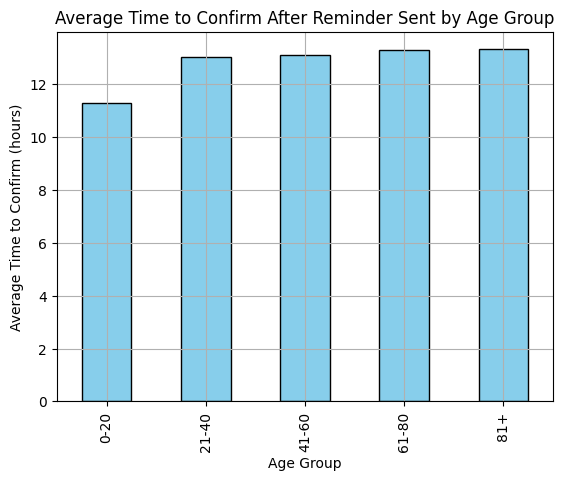

In [16]:
# Step 1: Filter for the Test group
test_group = ab_test_data[ab_test_data['group'] == 'Test']

# Step 2: Extract 'reminder_sent' and 'appointment_confirmed' events
reminder_sent = test_group[test_group['event_name'] == 'reminder_sent']
appointment_confirmed = test_group[test_group['event_name'] == 'appointment_confirmed']

# Step 3: Merge reminder_sent and appointment_confirmed on patient_id to get both events for each patient
merged_reminders = pd.merge(reminder_sent[['patient_id', 'event_datetime']], 
                            appointment_confirmed[['patient_id', 'event_datetime']], 
                            on='patient_id', 
                            suffixes=('_reminder_sent', '_confirmed'))

# Step 4: Convert event_datetime columns to datetime objects
merged_reminders['event_datetime_reminder_sent'] = pd.to_datetime(merged_reminders['event_datetime_reminder_sent'])
merged_reminders['event_datetime_confirmed'] = pd.to_datetime(merged_reminders['event_datetime_confirmed'])

# Step 5: Calculate the time difference (in hours) between reminder sent and appointment confirmed
merged_reminders['time_to_confirm'] = (merged_reminders['event_datetime_confirmed'] - 
                                       merged_reminders['event_datetime_reminder_sent']).dt.total_seconds() / 3600

# Step 6: Merge the age information from appointments_data with the merged_reminders
merged_reminders_with_age = pd.merge(merged_reminders, appointments_data[['patient_id', 'age']], on='patient_id', how='left')

# Step 7: Create age groups
merged_reminders_with_age['age_group'] = pd.cut(merged_reminders_with_age['age'], 
                                                bins=[0, 20, 40, 60, 80, 100], 
                                                labels=['0-20', '21-40', '41-60', '61-80', '81+'])

# Step 8: Group by age group and calculate the average time to confirm
age_group_response_time = merged_reminders_with_age.groupby('age_group')['time_to_confirm'].mean()

# Step 9: Display the average time to confirm for each age group
print(age_group_response_time)

# Step 10: Visualize the results

age_group_response_time.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Time to Confirm After Reminder Sent by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Time to Confirm (hours)')
plt.grid(True)
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_5882/1699781158.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  drop_off_by_age = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('age_group')['patient_id'].nunique()
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_5882/1699781158.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_patients_by_age = merged_data.groupby('age_group')['patient_id'].nunique()


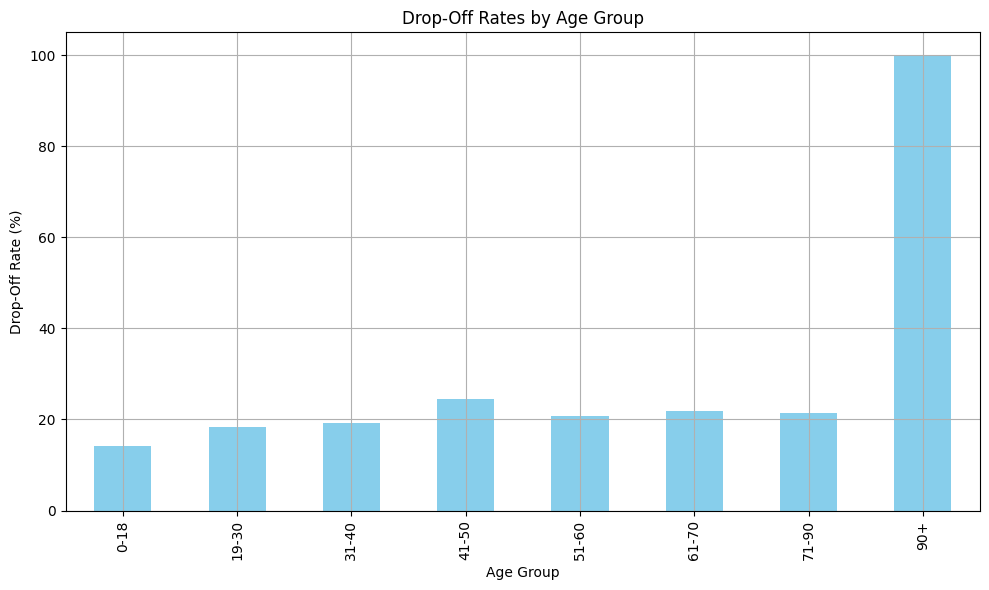

In [12]:

# Segment patients by age group
merged_data['age_group'] = pd.cut(merged_data['age'], bins=[0, 18, 30, 40, 50, 60, 70, 90, 120], labels=['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-90', '90+'])

# Calculate drop-off rates by age group
drop_off_by_age = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('age_group')['patient_id'].nunique()
total_patients_by_age = merged_data.groupby('age_group')['patient_id'].nunique()
drop_off_rate_by_age = (drop_off_by_age / total_patients_by_age) * 100

# Visualize drop-off rates by age group
plt.figure(figsize=(10, 6))
drop_off_rate_by_age.plot(kind='bar', color='skyblue')
plt.title('Drop-Off Rates by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Drop-Off Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


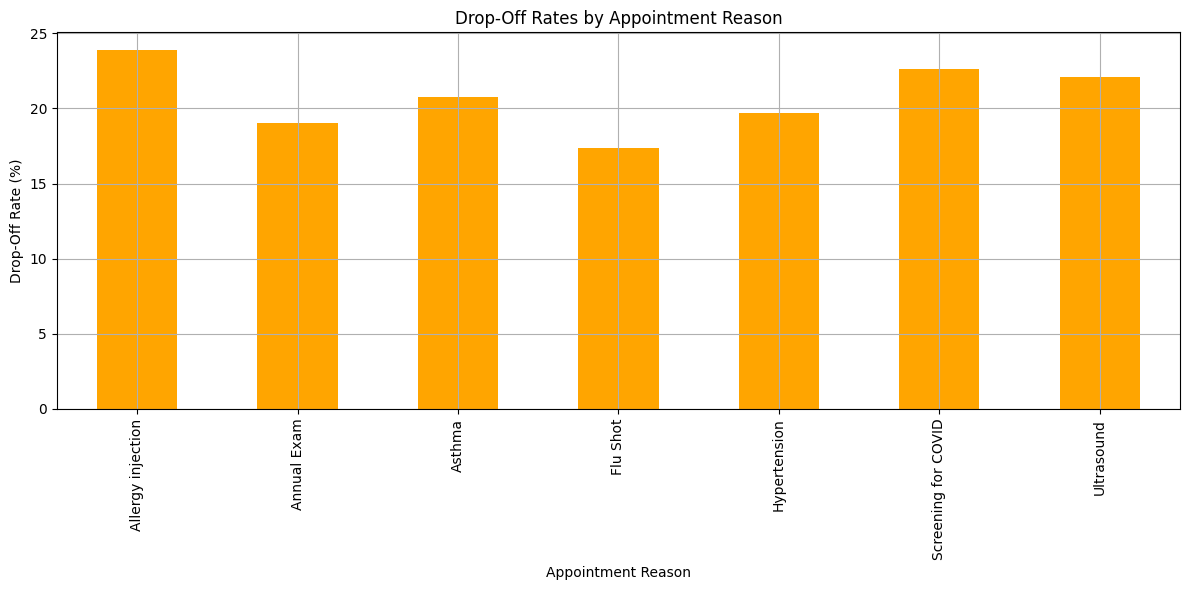

In [13]:
# Calculate drop-off rates by appointment reason
drop_off_by_reason = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('appointment_reason')['patient_id'].nunique()
total_patients_by_reason = merged_data.groupby('appointment_reason')['patient_id'].nunique()
drop_off_rate_by_reason = (drop_off_by_reason / total_patients_by_reason) * 100

# Visualize drop-off rates by appointment reason
plt.figure(figsize=(12, 6))
drop_off_rate_by_reason.plot(kind='bar', color='orange')
plt.title('Drop-Off Rates by Appointment Reason')
plt.xlabel('Appointment Reason')
plt.ylabel('Drop-Off Rate (%)')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


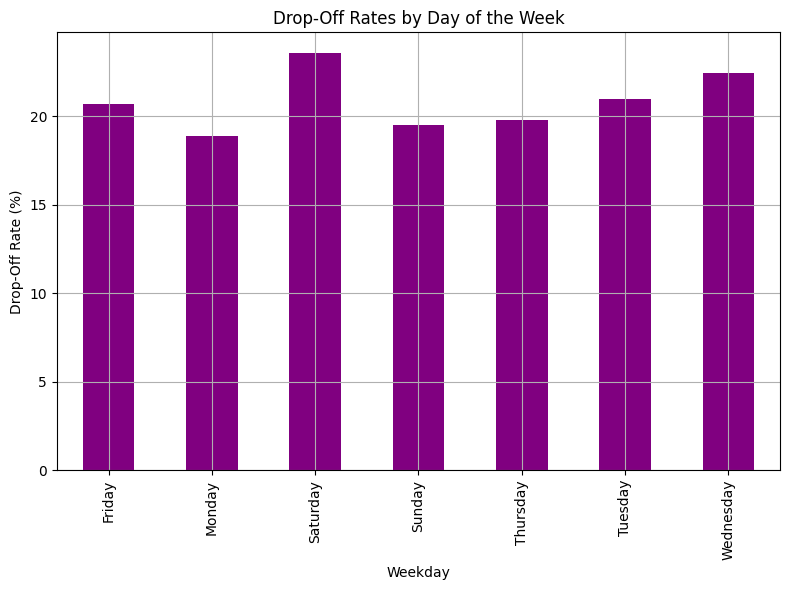

In [14]:
# Extract the weekday from the appointment date
merged_data['appointment_date'] = pd.to_datetime(merged_data['appointment_date'])
merged_data['weekday'] = merged_data['appointment_date'].dt.day_name()

# Calculate drop-off rates by day of the week
drop_off_by_weekday = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('weekday')['patient_id'].nunique()
total_patients_by_weekday = merged_data.groupby('weekday')['patient_id'].nunique()
drop_off_rate_by_weekday = (drop_off_by_weekday / total_patients_by_weekday) * 100

# Visualize drop-off rates by weekday
plt.figure(figsize=(8, 6))
drop_off_rate_by_weekday.plot(kind='bar', color='purple')
plt.title('Drop-Off Rates by Day of the Week')
plt.xlabel('Weekday')
plt.ylabel('Drop-Off Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


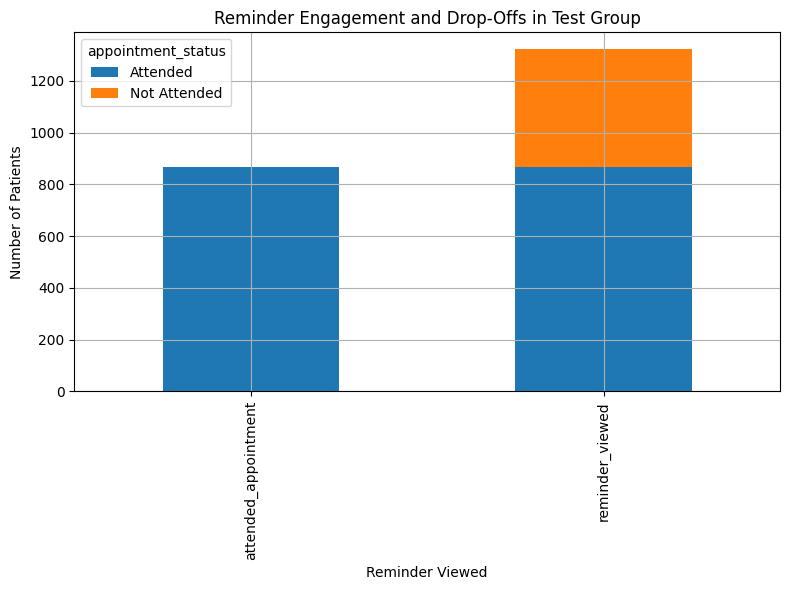

In [16]:

# Assuming 'event_name' contains 'reminder_viewed' events
reminder_engagement = test_group[test_group['event_name'].isin(['reminder_viewed', 'attended_appointment'])]

# Group by 'reminder_viewed' and 'appointment_status'
reminder_engagement = reminder_engagement.groupby(['event_name', 'appointment_status'])['patient_id'].nunique().unstack().fillna(0)

# Visualize reminder engagement vs. drop-offs
reminder_engagement.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Reminder Engagement and Drop-Offs in Test Group')
plt.xlabel('Reminder Viewed')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.tight_layout()
plt.show()



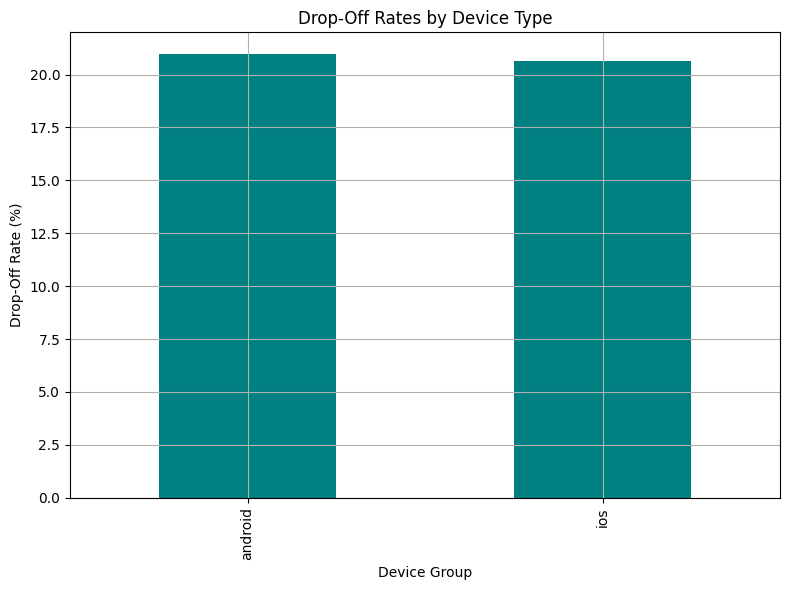

In [17]:

# First, map devices into groups: Android, iOS, and Other
app_data['device'] = app_data['device'].str.lower()  # Ensure all device names are in lowercase
app_data['device_group'] = app_data['device'].apply(lambda x: 'android' if 'android' in x else 'ios' if 'ios' in x else 'other')

# Reload and merge the datasets
# ab_test_data = pd.read_csv('/mnt/data/ab_test_data.csv')
# appointments_data = pd.read_csv('/mnt/data/appointments_data.csv')
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Ensure 'device_group' exists in the final merged_data
# Group by device type (Android, iOS, Other) and calculate drop-off rates
drop_off_by_device = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('device_group')['patient_id'].nunique()
total_patients_by_device = merged_data.groupby('device_group')['patient_id'].nunique()
drop_off_rate_by_device = (drop_off_by_device / total_patients_by_device) * 100

# Visualize drop-off rates by device type
plt.figure(figsize=(8, 6))
drop_off_rate_by_device.plot(kind='bar', color='teal')
plt.title('Drop-Off Rates by Device Type')
plt.xlabel('Device Group')
plt.ylabel('Drop-Off Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_5882/700758032.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  drop_off_by_lead_time = merged_data[merged_data['appointment_status'] != 'Attended'].groupby(lead_time_bins)['patient_id'].nunique()
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_5882/700758032.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_patients_by_lead_time = merged_data.groupby(lead_time_bins)['patient_id'].nunique()


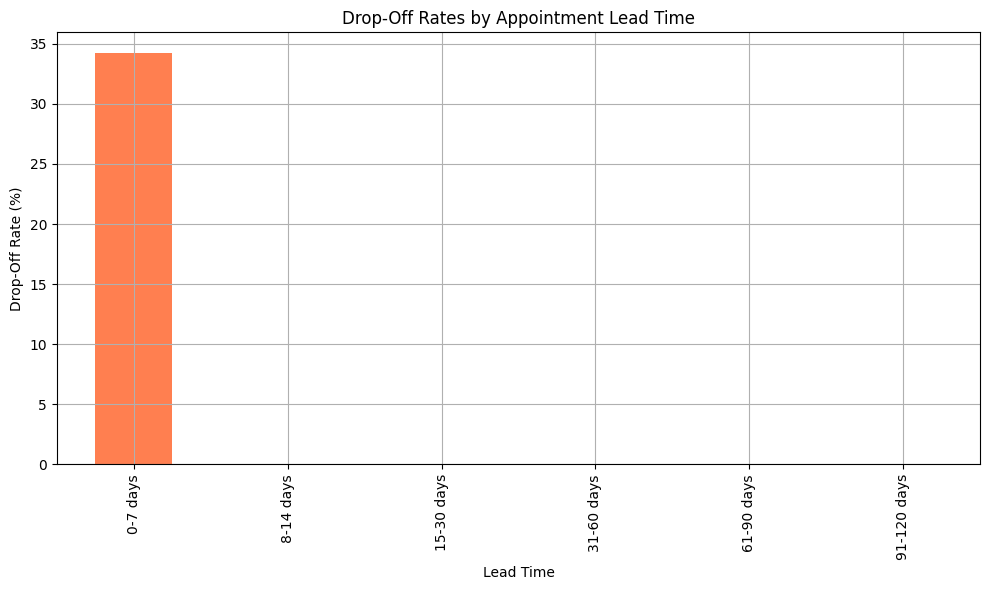

In [19]:
# Calculate the lead time (days between booking the appointment and the appointment date)
merged_data['appointment_date'] = pd.to_datetime(merged_data['appointment_date'])
merged_data['lead_time_days'] = (merged_data['appointment_date'] - pd.to_datetime(merged_data['event_datetime'])).dt.days

# Group by lead time ranges and calculate drop-off rates
lead_time_bins = pd.cut(merged_data['lead_time_days'], bins=[0, 7, 14, 30, 60, 90, 120], labels=['0-7 days', '8-14 days', '15-30 days', '31-60 days', '61-90 days', '91-120 days'])
drop_off_by_lead_time = merged_data[merged_data['appointment_status'] != 'Attended'].groupby(lead_time_bins)['patient_id'].nunique()
total_patients_by_lead_time = merged_data.groupby(lead_time_bins)['patient_id'].nunique()
drop_off_rate_by_lead_time = (drop_off_by_lead_time / total_patients_by_lead_time) * 100

# Visualize drop-off rates by lead time
plt.figure(figsize=(10, 6))
drop_off_rate_by_lead_time.plot(kind='bar', color='coral')
plt.title('Drop-Off Rates by Appointment Lead Time')
plt.xlabel('Lead Time')
plt.ylabel('Drop-Off Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_5882/382455120.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  drop_off_by_confirmation_time = test_group_times.groupby(confirmation_time_bins)['patient_id'].nunique()


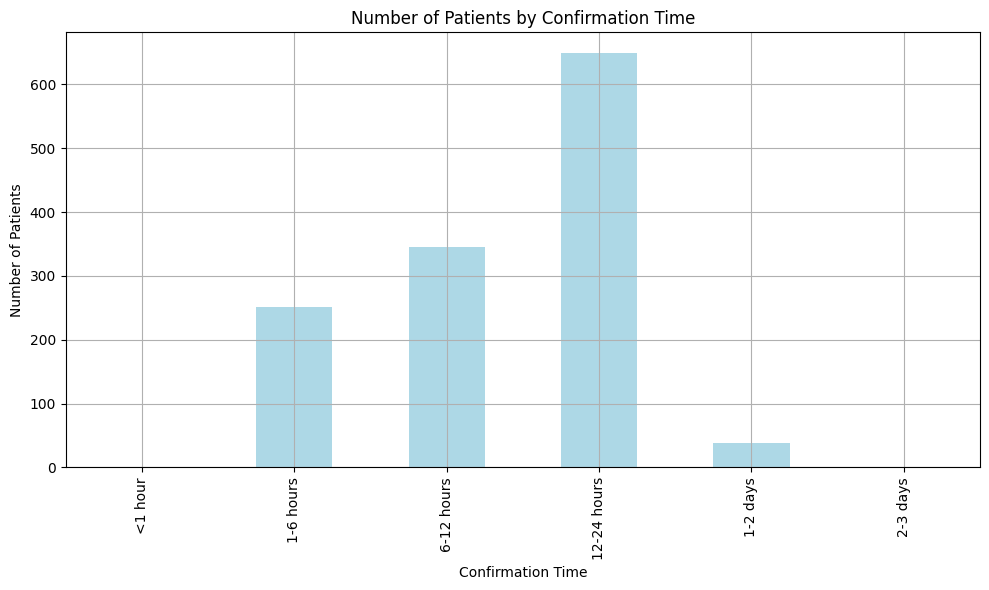

In [27]:
# Filter for the test group
test_group = merged_data[merged_data['group'] == 'Test']

# Extract the datetime for reminder_sent and appointment_confirmed events
reminder_sent = test_group[test_group['event_name'] == 'reminder_sent'][['patient_id', 'event_datetime']].rename(columns={'event_datetime': 'reminder_sent_datetime'})
appointment_confirmed = test_group[test_group['event_name'] == 'appointment_confirmed'][['patient_id', 'event_datetime']].rename(columns={'event_datetime': 'appointment_confirmed_datetime'})

# Merge the reminder_sent and appointment_confirmed data to calculate the time difference
test_group_times = pd.merge(reminder_sent, appointment_confirmed, on='patient_id', how='inner')

# Calculate the time difference between reminder_sent and appointment_confirmed in hours
test_group_times['confirmation_time'] = (pd.to_datetime(test_group_times['appointment_confirmed_datetime']) - pd.to_datetime(test_group_times['reminder_sent_datetime'])).dt.total_seconds() / 3600

# Group by confirmation time ranges and calculate drop-off rates
confirmation_time_bins = pd.cut(test_group_times['confirmation_time'], bins=[0, 1, 6, 12, 24, 48, 72], labels=['<1 hour', '1-6 hours', '6-12 hours', '12-24 hours', '1-2 days', '2-3 days'])
drop_off_by_confirmation_time = test_group_times.groupby(confirmation_time_bins)['patient_id'].nunique()

# Visualize drop-off rates by confirmation time
plt.figure(figsize=(10, 6))
drop_off_by_confirmation_time.plot(kind='bar', color='lightblue')
plt.title('Number of Patients by Confirmation Time')
plt.xlabel('Confirmation Time')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.tight_layout()
plt.show()


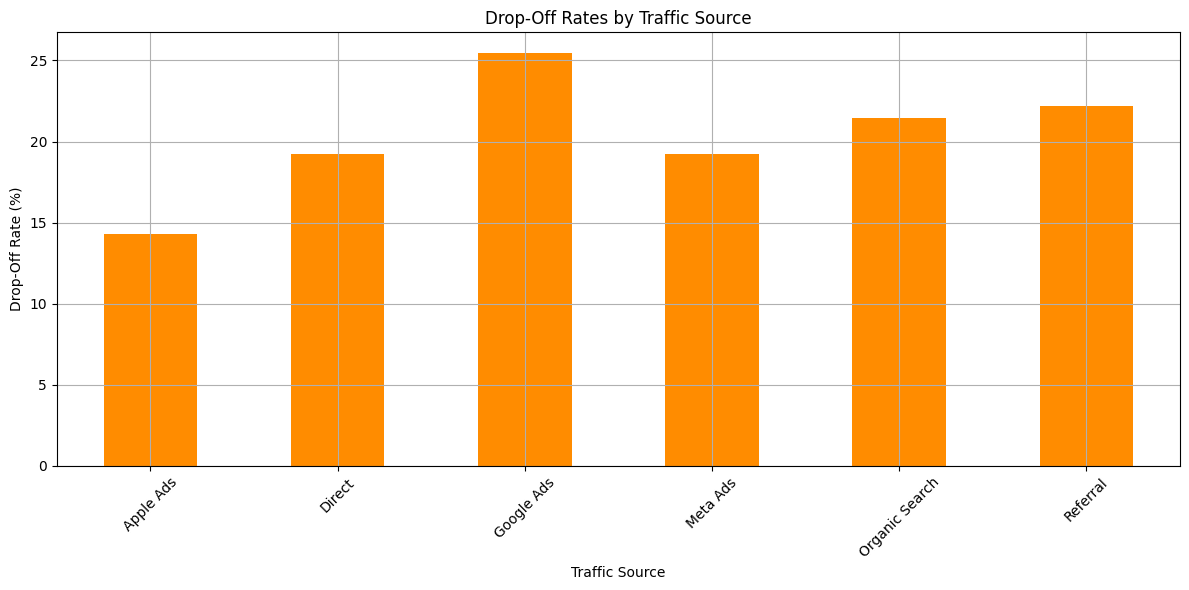

In [21]:
# Group by traffic source and calculate drop-off rates
drop_off_by_traffic = merged_data[merged_data['appointment_status'] != 'Attended'].groupby('traffic_source')['patient_id'].nunique()
total_patients_by_traffic = merged_data.groupby('traffic_source')['patient_id'].nunique()
drop_off_rate_by_traffic = (drop_off_by_traffic / total_patients_by_traffic) * 100

# Visualize drop-off rates by traffic source
plt.figure(figsize=(12, 6))
drop_off_rate_by_traffic.plot(kind='bar', color='darkorange')
plt.title('Drop-Off Rates by Traffic Source')
plt.xlabel('Traffic Source')
plt.ylabel('Drop-Off Rate (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_5882/3976619324.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_appointments['event_datetime'] = pd.to_datetime(confirmed_appointments['event_datetime'])
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_5882/3976619324.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_appointments['confirmation_date'] = confirmed_appointments['event_datetime'].dt.date


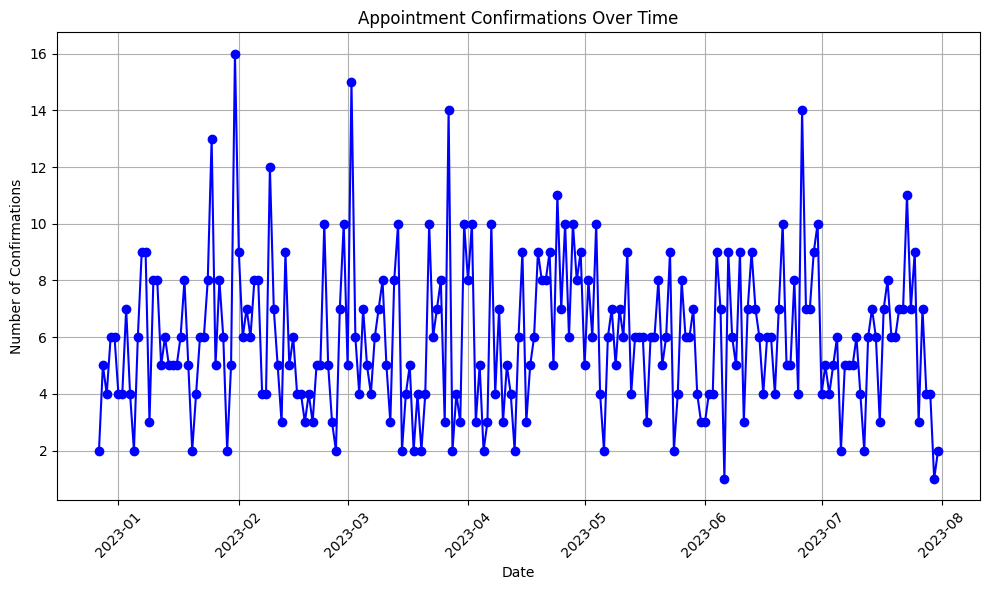

In [9]:
# Step 1: Filter for 'appointment_confirmed' events in both Test and Control groups
confirmed_appointments = ab_test_data[ab_test_data['event_name'] == 'appointment_confirmed']

# Step 2: Convert event_datetime to datetime format
confirmed_appointments['event_datetime'] = pd.to_datetime(confirmed_appointments['event_datetime'])

# Step 3: Extract the date (or week) from event_datetime to group by day (or week)
confirmed_appointments['confirmation_date'] = confirmed_appointments['event_datetime'].dt.date

# Step 4: Group by the confirmation date and count the number of confirmations per day
confirmations_over_time = confirmed_appointments.groupby('confirmation_date')['patient_id'].count()

# Step 5: Visualize the confirmation trend over time
plt.figure(figsize=(10, 6))
confirmations_over_time.plot(kind='line', marker='o', linestyle='-', color='blue')
plt.title('Appointment Confirmations Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Confirmations')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


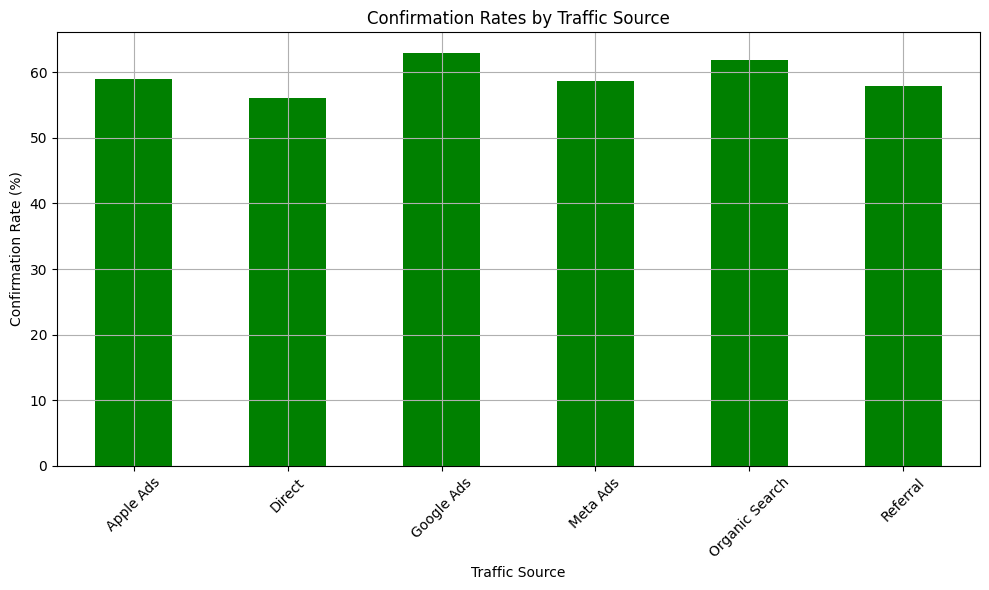

In [ ]:

# Merge the data: ab_test_data with appointments_data and app_data on patient_id
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Step 1: Filter for 'appointment_confirmed' events
confirmed_data = merged_data[merged_data['event_name'] == 'appointment_confirmed']

# Step 2: Calculate the number of confirmed appointments per traffic source
confirmations_by_source = confirmed_data.groupby('traffic_source')['patient_id'].nunique()

# Step 3: Calculate the total number of patients per traffic source
total_patients_by_source = merged_data.groupby('traffic_source')['patient_id'].nunique()

# Step 4: Calculate confirmation rate by traffic source
confirmation_rate_by_source = (confirmations_by_source / total_patients_by_source) * 100

# Step 5: Visualize the confirmation rates by traffic source
confirmation_rate_by_source.plot(kind='bar', figsize=(10, 6), color='green')
plt.title('Confirmation Rates by Traffic Source')
plt.xlabel('Traffic Source')
plt.ylabel('Confirmation Rate (%)')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


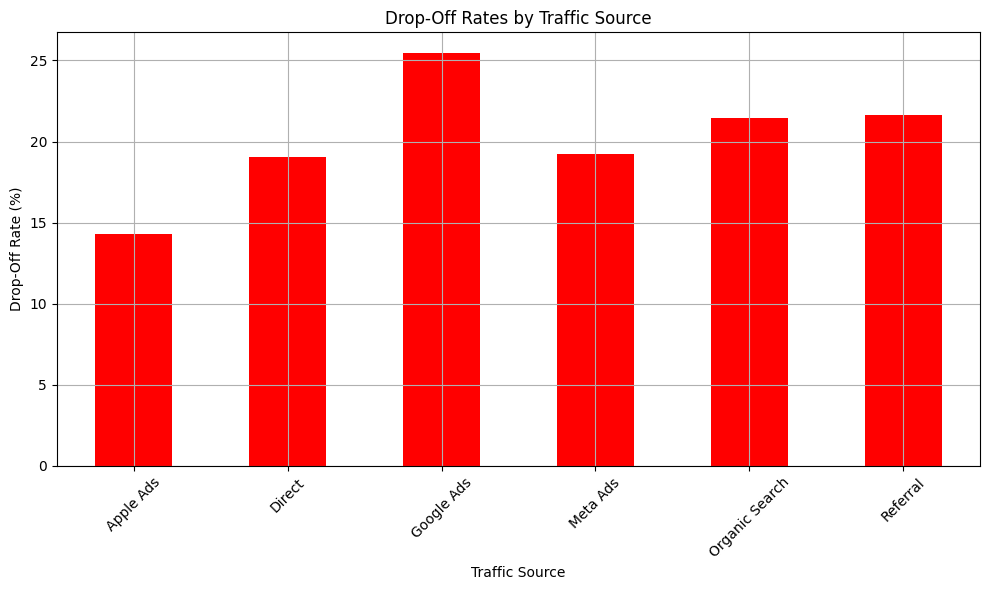

In [18]:

# Merge the data: ab_test_data with appointments_data and app_data on patient_id
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Step 1: Define drop-offs
# Drop-offs: Patients who were sent a reminder but did not confirm or attend the appointment
merged_data['drop_off'] = merged_data.apply(lambda x: 1 if (x['event_name'] == 'reminder_sent') and 
                                             (x['appointment_status'] != 'Attended') and 
                                             (x['event_name'] != 'appointment_confirmed') else 0, axis=1)

# Step 2: Group by traffic source and calculate total drop-offs and total patients
drop_offs_by_source = merged_data.groupby('traffic_source')['drop_off'].sum()
total_patients_by_source = merged_data.groupby('traffic_source')['patient_id'].nunique()

# Step 3: Calculate drop-off rate by traffic source
drop_off_rate_by_source = (drop_offs_by_source / total_patients_by_source) * 100

# Step 4: Visualize the drop-off rates by traffic source
drop_off_rate_by_source.plot(kind='bar', figsize=(10, 6), color='red')
plt.title('Drop-Off Rates by Traffic Source')
plt.xlabel('Traffic Source')
plt.ylabel('Drop-Off Rate (%)')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


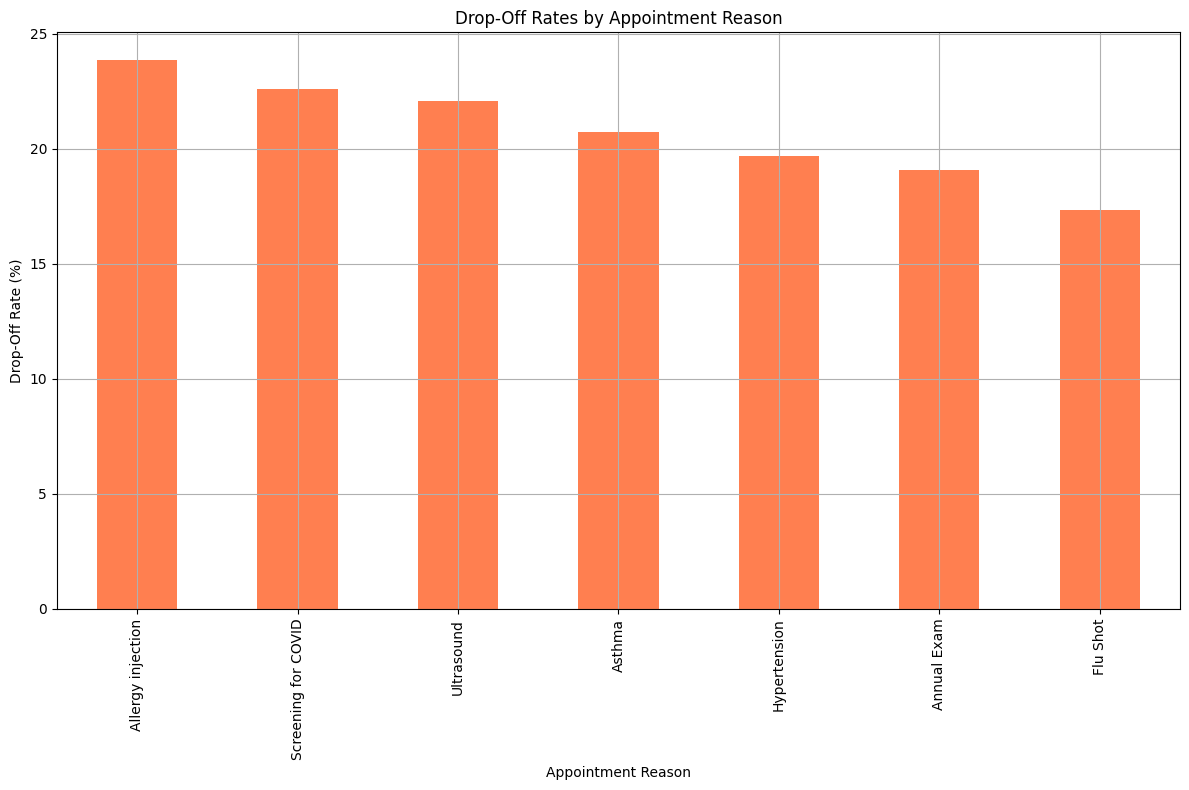

In [28]:
# Group by appointment reason and calculate attendance and drop-offs
attendance_by_reason = merged_data.groupby(['appointment_reason', 'appointment_status'])['patient_id'].nunique().unstack().fillna(0)

# Calculate drop-off rate as the percentage of patients who did not attend out of the total patients
attendance_by_reason['drop_off_rate'] = (attendance_by_reason['Not Attended'] / (attendance_by_reason['Attended'] + attendance_by_reason['Not Attended'])) * 100

# Visualize the drop-off rates by appointment reason
plt.figure(figsize=(12, 8))
attendance_by_reason['drop_off_rate'].sort_values(ascending=False).plot(kind='bar', color='coral')
plt.title('Drop-Off Rates by Appointment Reason')
plt.xlabel('Appointment Reason')
plt.ylabel('Drop-Off Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


Control Group Attendance Rate: 100.0
Test Group Attendance Rate: 18.07555833855145
Control Group Counts: {'Total Control Group': 869, 'Attended Control Group': 869}
Test Group Counts: {'Total Test Group': 4791, 'Attended Test Group': 866}


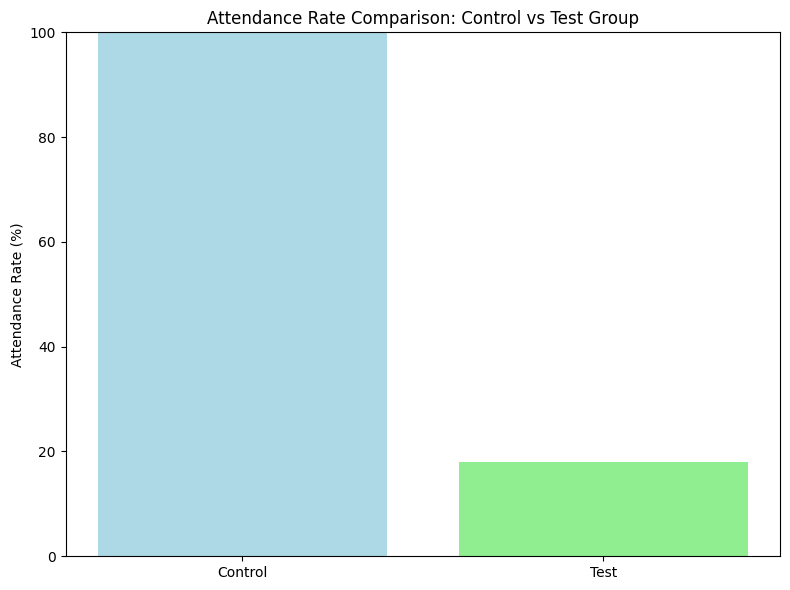

In [3]:
# Group the data
control_attended = ab_test_data[(ab_test_data['group'] == 'Control') & (ab_test_data['event_name'] == 'attended_appointment')]
test_attended = ab_test_data[(ab_test_data['group'] == 'Test') & (ab_test_data['event_name'] == 'attended_appointment')]

# Total number of entries in each group
total_control = ab_test_data[ab_test_data['group'] == 'Control'].shape[0]
total_test = ab_test_data[ab_test_data['group'] == 'Test'].shape[0]

# Number of attended appointments in each group
attended_control = control_attended.shape[0]
attended_test = test_attended.shape[0]

# Attendance rates
control_attendance_rate = (attended_control / total_control) * 100
test_attendance_rate = (attended_test / total_test) * 100

# Provide the counts for total and attended appointments in both groups
control_attendance_counts = {
    'Total Control Group': total_control,
    'Attended Control Group': attended_control
}

test_attendance_counts = {
    'Total Test Group': total_test,
    'Attended Test Group': attended_test
}

# Display the results
print("Control Group Attendance Rate:", control_attendance_rate)
print("Test Group Attendance Rate:", test_attendance_rate)

print("Control Group Counts:", control_attendance_counts)
print("Test Group Counts:", test_attendance_counts)

# Visualizing attendance rate comparison between Control and Test groups

# Data for visualization
groups = ['Control', 'Test']
attendance_rates = [control_attendance_rate, test_attendance_rate]

# Plotting the bar chart for attendance rates comparison
plt.figure(figsize=(8, 6))
plt.bar(groups, attendance_rates, color=['lightblue', 'lightgreen'])
plt.ylabel('Attendance Rate (%)')
plt.title('Attendance Rate Comparison: Control vs Test Group')
plt.ylim(0, 100)

# Display the plot
plt.tight_layout()
plt.show()



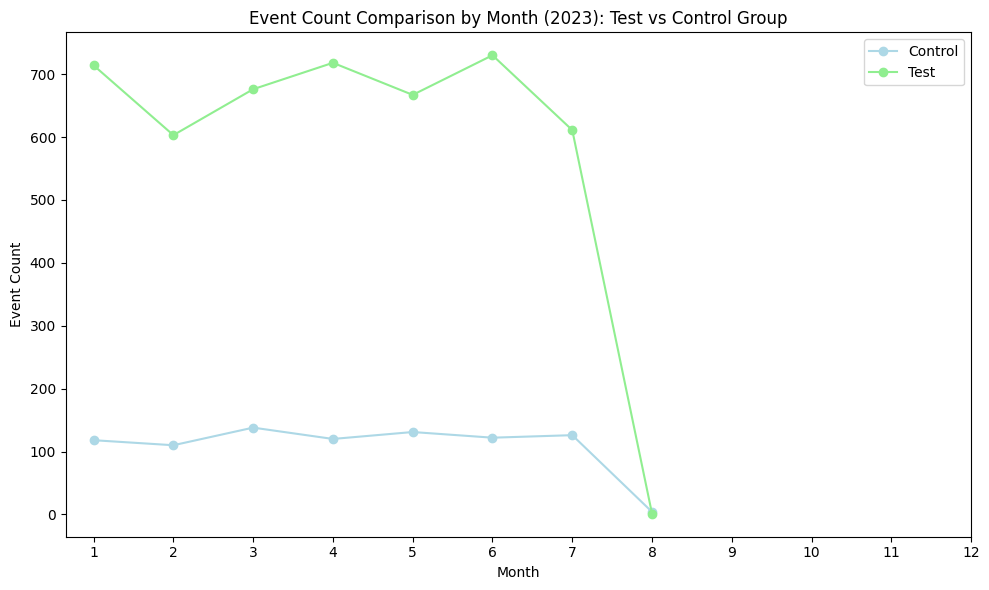

In [4]:
# Ensure 'event_datetime' is in datetime format
ab_test_data['event_datetime'] = pd.to_datetime(ab_test_data['event_datetime'])

# Extract the year from the 'event_datetime' for time-based analysis
ab_test_data['year'] = ab_test_data['event_datetime'].dt.year
ab_test_data['month'] = ab_test_data['event_datetime'].dt.month

# Filter data for the year 2023
data_2023 = ab_test_data[ab_test_data['year'] == 2023]

# Grouping by 'group' and 'month' for 2023
monthly_data_2023 = data_2023.groupby(['group', 'month']).size().reset_index(name='count')

# Plotting comparison for Test and Control groups by month in 2023
plt.figure(figsize=(10, 6))

# Plotting for Control group
control_data_2023 = monthly_data_2023[monthly_data_2023['group'] == 'Control']
plt.plot(control_data_2023['month'], control_data_2023['count'], label='Control', marker='o', color='lightblue')

# Plotting for Test group
test_data_2023 = monthly_data_2023[monthly_data_2023['group'] == 'Test']
plt.plot(test_data_2023['month'], test_data_2023['count'], label='Test', marker='o', color='lightgreen')

plt.xlabel('Month')
plt.ylabel('Event Count')
plt.title('Event Count Comparison by Month (2023): Test vs Control Group')
plt.xticks(range(1, 13))
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


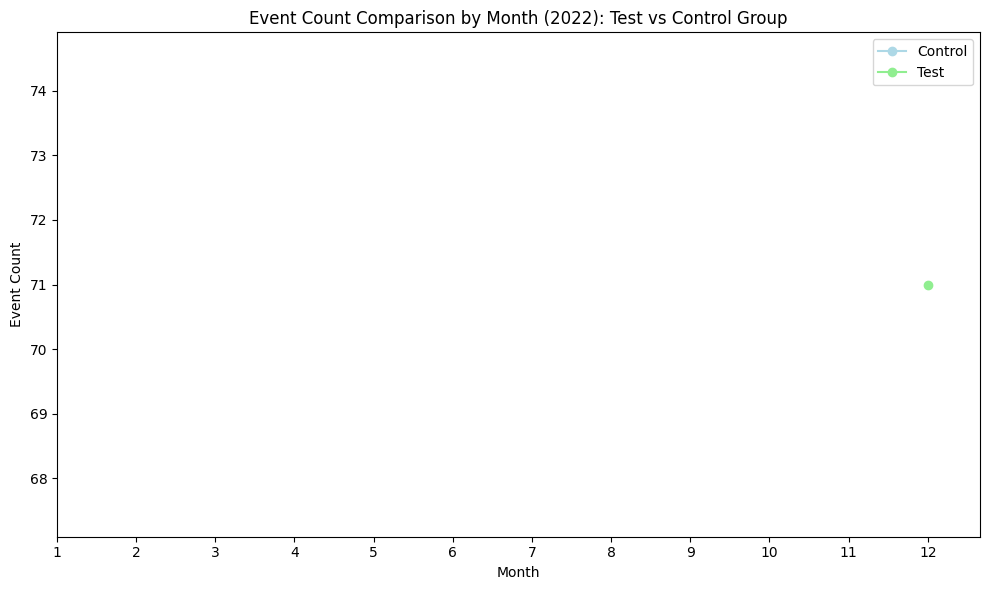

In [5]:
# Filter data for the year 2022
data_2022 = ab_test_data[ab_test_data['year'] == 2022]

# Grouping by 'group' and 'month' for 2022
monthly_data_2022 = data_2022.groupby(['group', 'month']).size().reset_index(name='count')

# Plotting comparison for Test and Control groups by month in 2022
plt.figure(figsize=(10, 6))

# Plotting for Control group
control_data_2022 = monthly_data_2022[monthly_data_2022['group'] == 'Control']
plt.plot(control_data_2022['month'], control_data_2022['count'], label='Control', marker='o', color='lightblue')

# Plotting for Test group
test_data_2022 = monthly_data_2022[monthly_data_2022['group'] == 'Test']
plt.plot(test_data_2022['month'], test_data_2022['count'], label='Test', marker='o', color='lightgreen')

plt.xlabel('Month')
plt.ylabel('Event Count')
plt.title('Event Count Comparison by Month (2022): Test vs Control Group')
plt.xticks(range(1, 13))
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


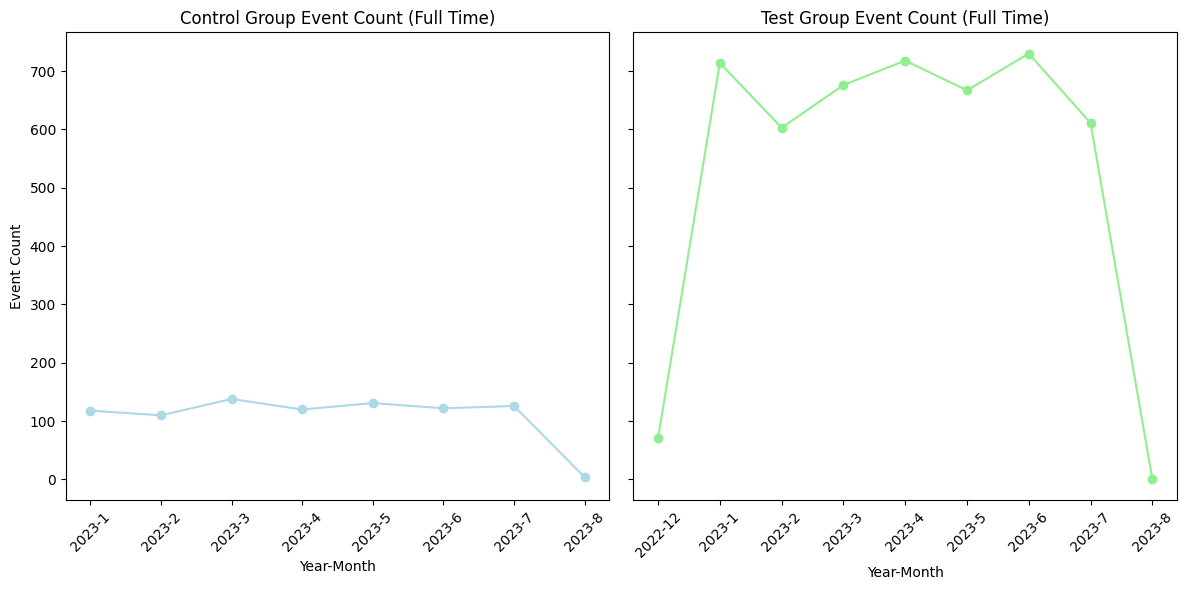

In [8]:
# Group the data by 'group', 'year', and 'month' to visualize the entire time span for Control and Test groups
full_time_data = ab_test_data.groupby(['group', 'year', 'month']).size().reset_index(name='count')

# Plot separate line charts for Control and Test groups for all available years and months
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Control group
control_full_time = full_time_data[full_time_data['group'] == 'Control']
axes[0].plot(control_full_time['year'].astype(str) + '-' + control_full_time['month'].astype(str), 
             control_full_time['count'], marker='o', color='lightblue')
axes[0].set_title('Control Group Event Count (Full Time)')
axes[0].set_xlabel('Year-Month')
axes[0].set_ylabel('Event Count')
axes[0].set_xticks(control_full_time['year'].astype(str) + '-' + control_full_time['month'].astype(str))
axes[0].tick_params(axis='x', rotation=45)

# Test group
test_full_time = full_time_data[full_time_data['group'] == 'Test']
axes[1].plot(test_full_time['year'].astype(str) + '-' + test_full_time['month'].astype(str), 
             test_full_time['count'], marker='o', color='lightgreen')
axes[1].set_title('Test Group Event Count (Full Time)')
axes[1].set_xlabel('Year-Month')
axes[1].set_xticks(test_full_time['year'].astype(str) + '-' + test_full_time['month'].astype(str))
axes[1].tick_params(axis='x', rotation=45)

# Display the plots
plt.tight_layout()
plt.show()


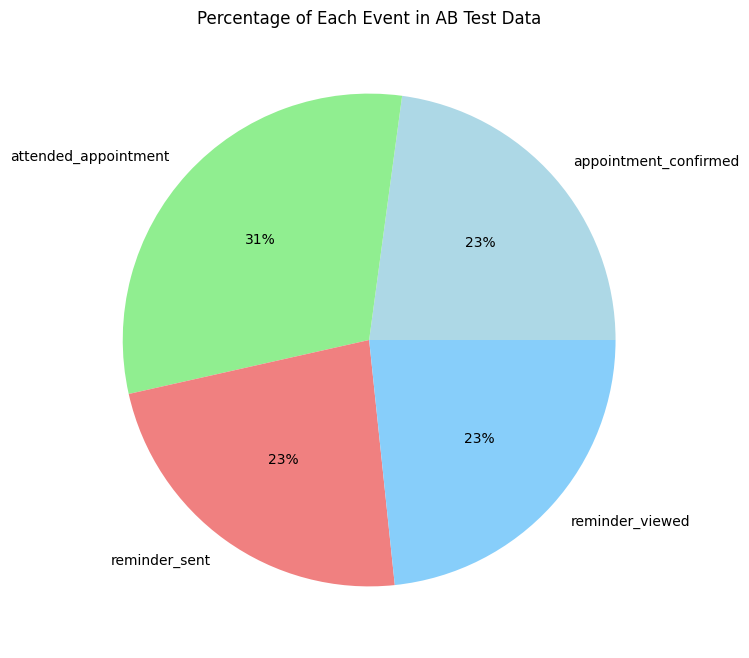

In [9]:
# Grouping by 'event_name' and calculating the count
grouped_ab_test_data = ab_test_data.groupby('event_name').size().reset_index(name='count')

# Calculate the percentage for each event
grouped_ab_test_data['percentage'] = (grouped_ab_test_data['count'] / grouped_ab_test_data['count'].sum()) * 100

# Plotting the pie chart with percentages for each event
plt.figure(figsize=(8, 8))
plt.pie(grouped_ab_test_data['percentage'], labels=grouped_ab_test_data['event_name'], autopct='%1.0f%%', colors=['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue'])
plt.title('Percentage of Each Event in AB Test Data')

# Display the pie chart
plt.show()


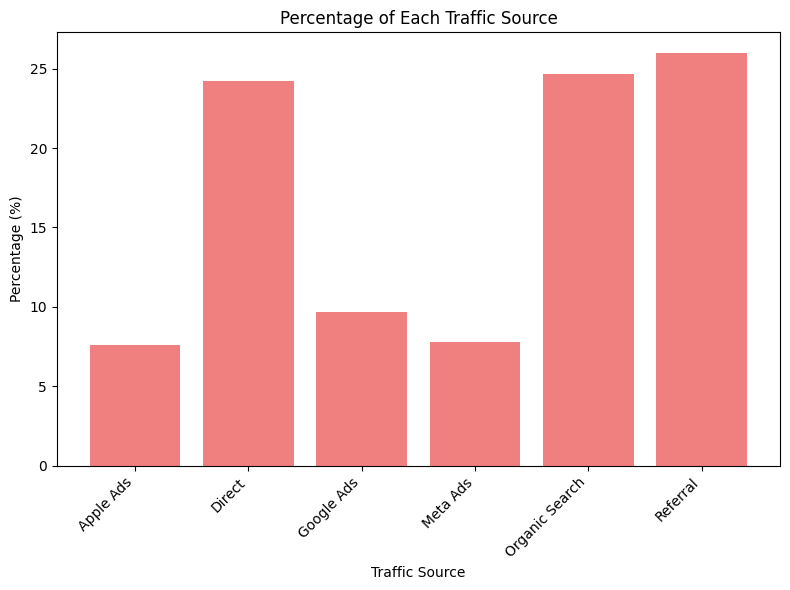

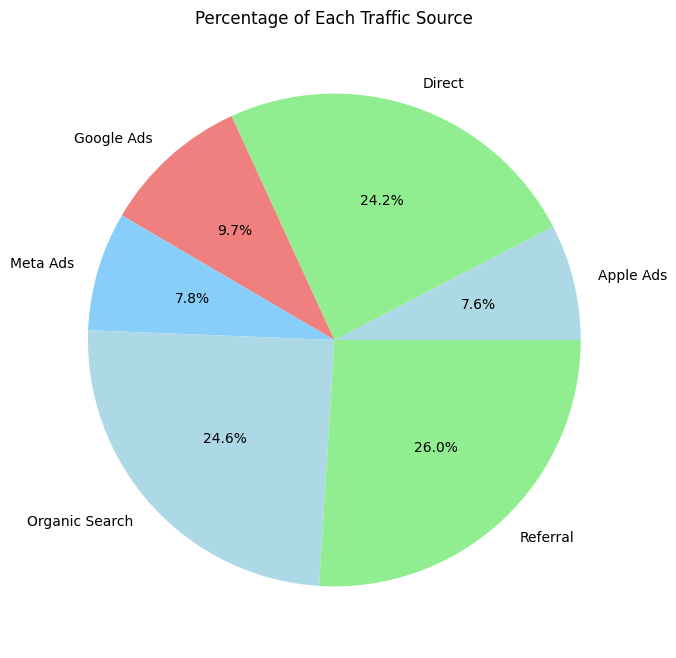

In [16]:
# Grouping the app_data by 'traffic_source' and calculating the count and percentages
grouped_traffic_source = app_data.groupby('traffic_source').size().reset_index(name='count')
grouped_traffic_source['percentage'] = (grouped_traffic_source['count'] / grouped_traffic_source['count'].sum()) * 100

# Plotting the bar chart for traffic source with percentages
plt.figure(figsize=(8, 6))
plt.bar(grouped_traffic_source['traffic_source'], grouped_traffic_source['percentage'], color='lightcoral')
plt.xlabel('Traffic Source')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Each Traffic Source')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plotting the pie chart for traffic source
plt.figure(figsize=(8, 8))
plt.pie(grouped_traffic_source['percentage'], labels=grouped_traffic_source['traffic_source'], autopct='%1.1f%%', colors=['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue'])
plt.title('Percentage of Each Traffic Source')
plt.show()


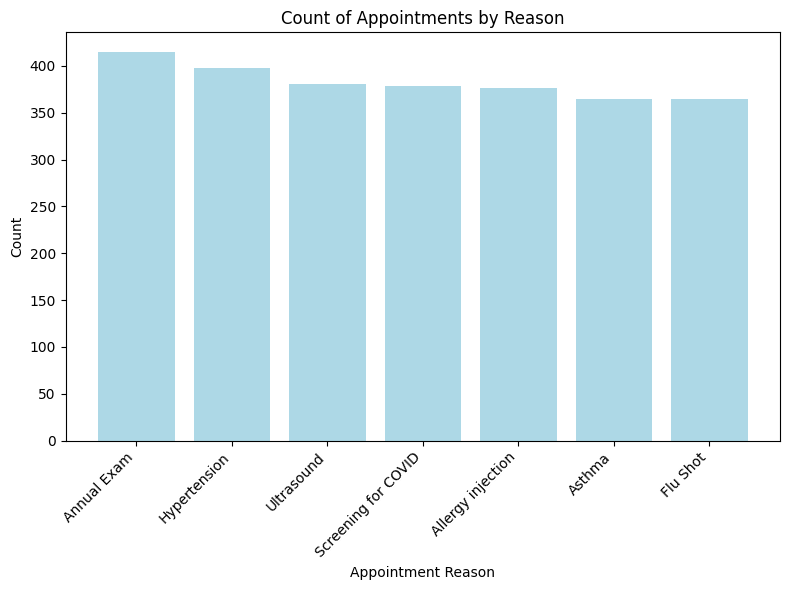

In [20]:
# Grouping by 'appointment_reason' and counting, then ordering by count from most to least
grouped_appointments = appointments_data.groupby('appointment_reason').size().reset_index(name='count')
grouped_appointments = grouped_appointments.sort_values(by='count', ascending=False)

grouped_appointments.reset_index(drop=True)
# Visualizing the appointment reason counts with a bar chart
plt.figure(figsize=(8, 6))
plt.bar(grouped_appointments['appointment_reason'], grouped_appointments['count'], color='lightblue')
plt.xlabel('Appointment Reason')
plt.ylabel('Count')
plt.title('Count of Appointments by Reason')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


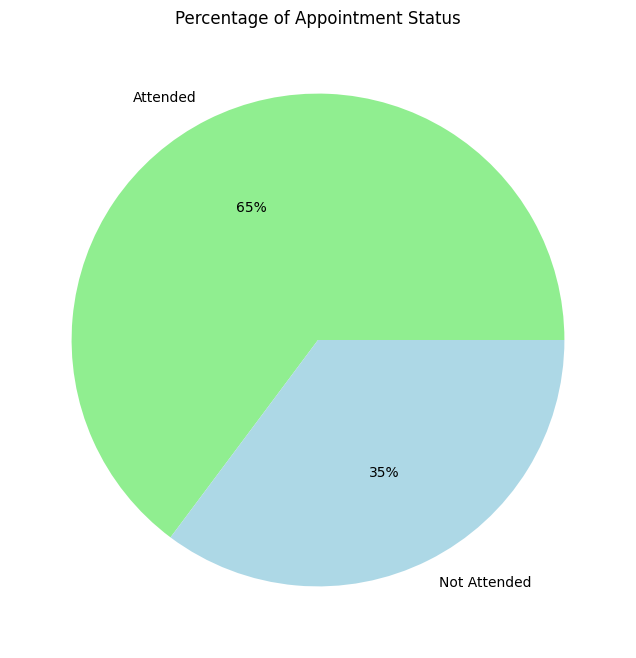

In [21]:
# Grouping by 'appointment_status' and counting, then ordering by count from highest to lowest
grouped_status = appointments_data.groupby('appointment_status').size().reset_index(name='count')
grouped_status = grouped_status.sort_values(by='count', ascending=False).reset_index(drop=True)

# Calculate the percentage for each appointment status
grouped_status['percentage'] = (grouped_status['count'] / grouped_status['count'].sum()) * 100

# Plotting the pie chart with percentages for appointment status
plt.figure(figsize=(8, 8))
plt.pie(grouped_status['percentage'], labels=grouped_status['appointment_status'], autopct='%1.0f%%', colors=['lightgreen', 'lightblue'])
plt.title('Percentage of Appointment Status')

# Display the pie chart
plt.show()


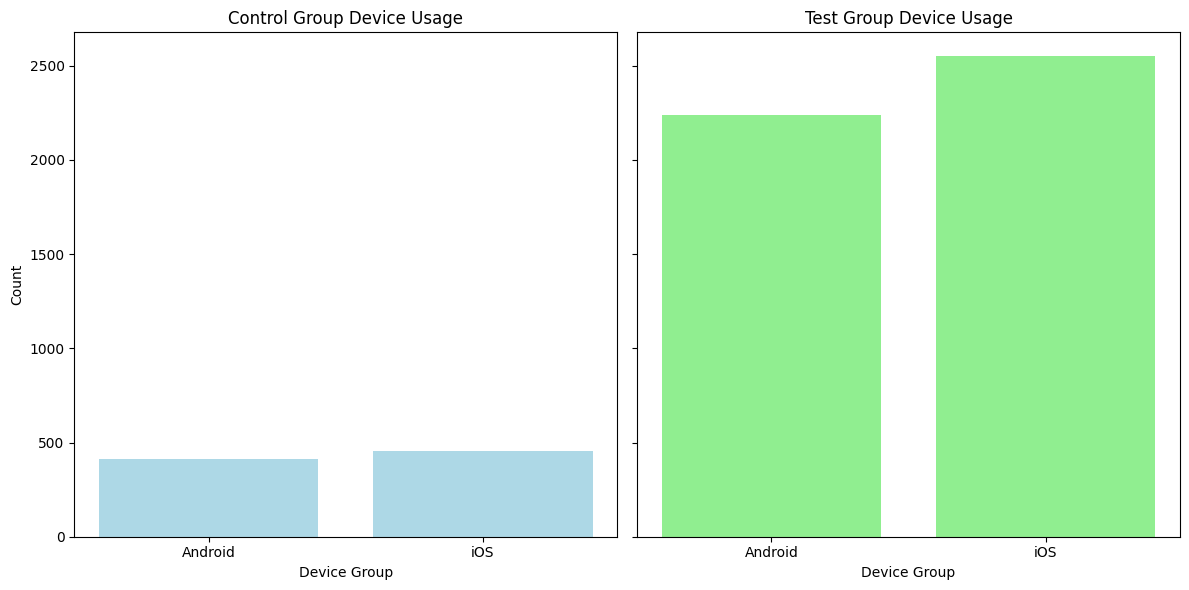

In [24]:
# Group devices into Android and iOS
merged_data['device_group'] = merged_data['device'].str.lower().apply(lambda x: 'Android' if 'android' in x else 'iOS')

# Grouping by 'group' and 'device_group' to get the counts for Control and Test groups
device_group_counts = merged_data.groupby(['group', 'device_group']).size().reset_index(name='count')

# Separate data for Control and Test groups
control_devices_grouped = device_group_counts[device_group_counts['group'] == 'Control']
test_devices_grouped = device_group_counts[device_group_counts['group'] == 'Test']

# Plotting separate bar charts for Control and Test groups
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Control group plot
axes[0].bar(control_devices_grouped['device_group'], control_devices_grouped['count'], color='lightblue')
axes[0].set_title('Control Group Device Usage')
axes[0].set_xlabel('Device Group')
axes[0].set_ylabel('Count')

# Test group plot
axes[1].bar(test_devices_grouped['device_group'], test_devices_grouped['count'], color='lightgreen')
axes[1].set_title('Test Group Device Usage')
axes[1].set_xlabel('Device Group')

# Display the plots
plt.tight_layout()
plt.show()


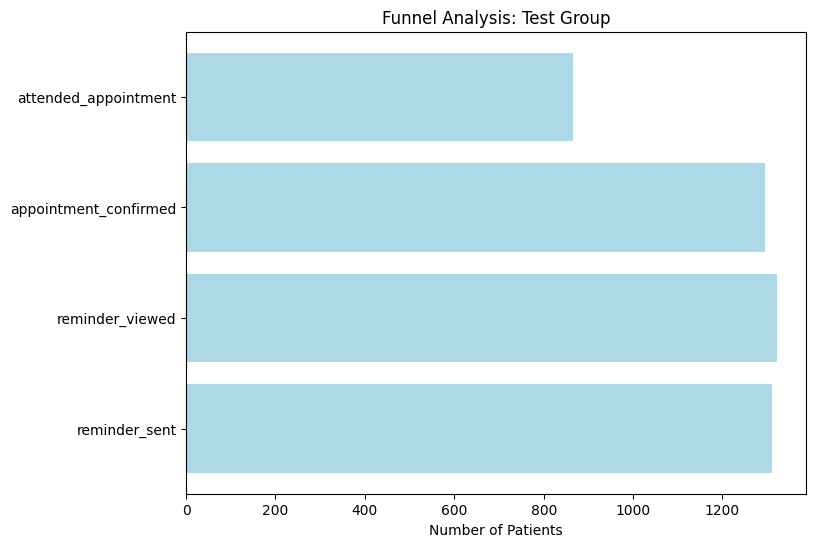

In [24]:
funnel = merged_data[merged_data['group'] == 'Test']
funnel_stages = funnel['event_name'].value_counts()

# Plot funnel
stages = ['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment']
values = [funnel_stages[stage] if stage in funnel_stages else 0 for stage in stages]

plt.figure(figsize=(8, 6))
plt.barh(stages, values, color='lightblue')
plt.xlabel('Number of Patients')
plt.title('Funnel Analysis: Test Group')
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_9309/1646225987.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_analysis = merged_data.groupby('age_group')['appointment_status'].value_counts(normalize=True).unstack().fillna(0) * 100


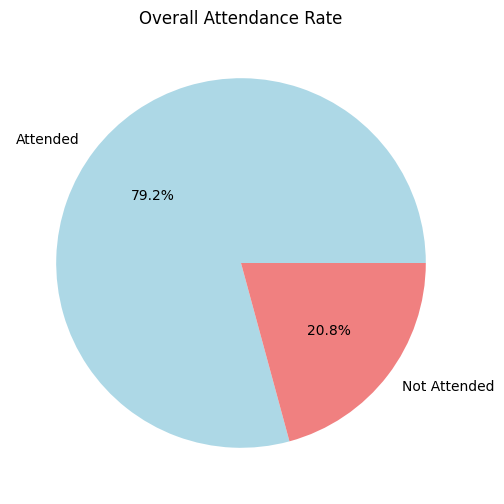

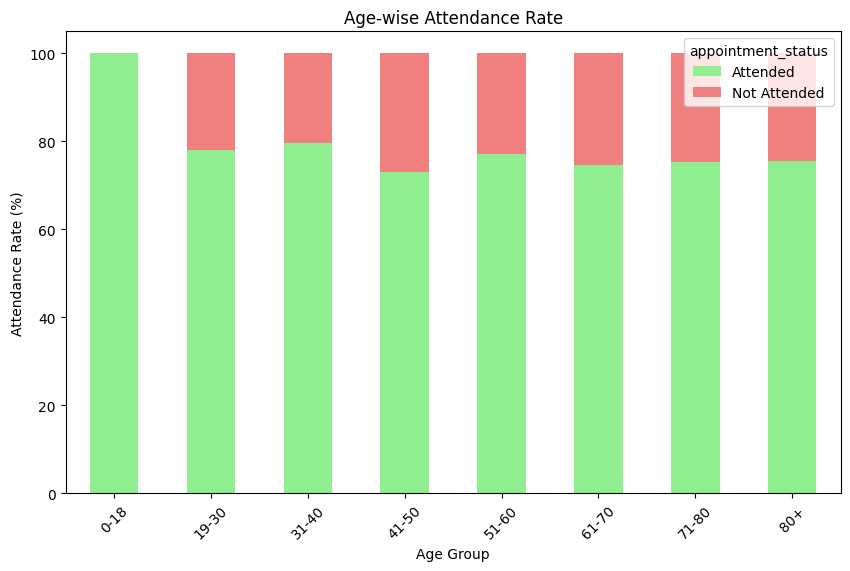

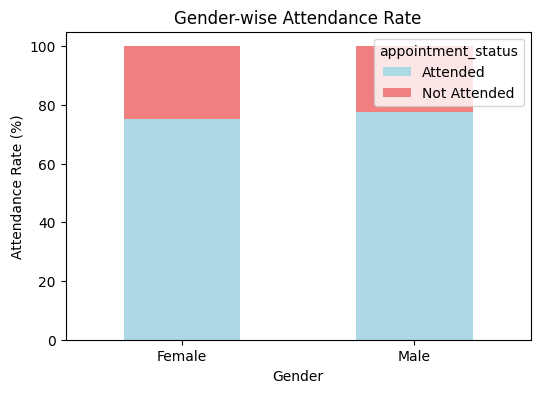

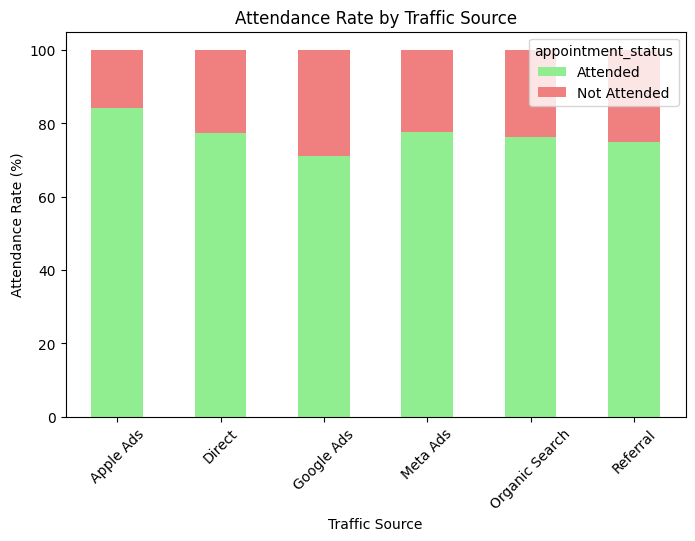

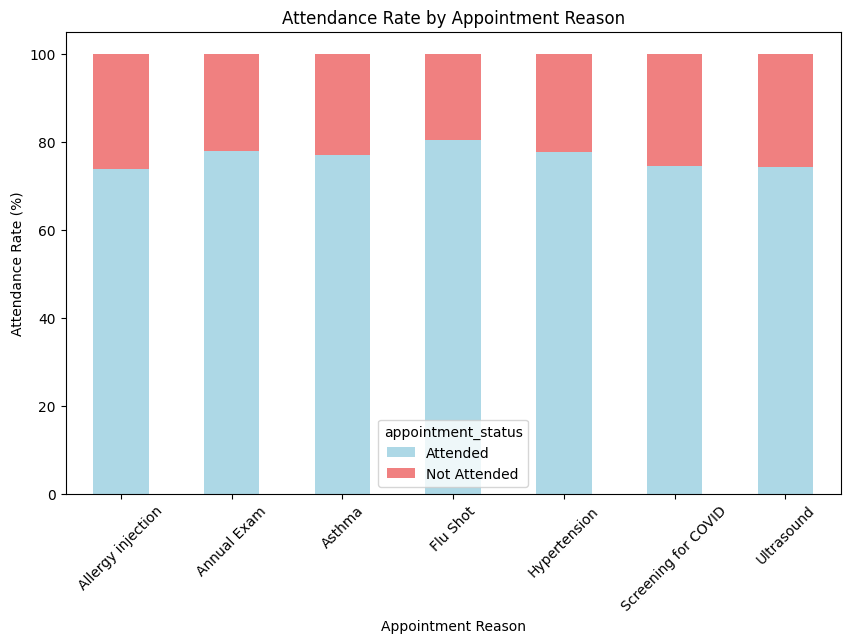

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the necessary data
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Merge the datasets
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Group devices into Android, iOS, and Other
merged_data['device_group'] = merged_data['device'].str.lower().apply(lambda x: 'android' if 'android' in x else ('ios' if 'ios' in x else 'other'))

# Create age groups
bins = [0, 18, 30, 40, 50, 60, 70, 80, 100]
labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-80', '80+']
merged_data['age_group'] = pd.cut(merged_data['age'], bins=bins, labels=labels, right=False)

# Attendance rate
attended = merged_data[merged_data['appointment_status'] == 'Attended']['patient_id'].nunique()
total_patients = merged_data['patient_id'].nunique()
attendance_rate = (attended / total_patients) * 100

# Age-wise attendance rate
age_analysis = merged_data.groupby('age_group')['appointment_status'].value_counts(normalize=True).unstack().fillna(0) * 100

# Gender-wise attendance rate
gender_analysis = merged_data.groupby('gender')['appointment_status'].value_counts(normalize=True).unstack().fillna(0) * 100

# Traffic source-wise attendance rate
traffic_source_analysis = merged_data.groupby('traffic_source')['appointment_status'].value_counts(normalize=True).unstack().fillna(0) * 100

# Appointment reason-wise attendance rate
appointment_reason_analysis = merged_data.groupby('appointment_reason')['appointment_status'].value_counts(normalize=True).unstack().fillna(0) * 100

# Visualization

# Overall attendance rate
plt.figure(figsize=(6, 6))
plt.pie([attendance_rate, 100 - attendance_rate], labels=['Attended', 'Not Attended'], autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Overall Attendance Rate')
plt.show()

# Age-wise attendance rate visualization
age_analysis.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightgreen', 'lightcoral'])
plt.title('Age-wise Attendance Rate')
plt.ylabel('Attendance Rate (%)')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.show()

# Gender-wise attendance rate visualization
gender_analysis.plot(kind='bar', stacked=True, figsize=(6, 4), color=['lightblue', 'lightcoral'])
plt.title('Gender-wise Attendance Rate')
plt.ylabel('Attendance Rate (%)')
plt.xlabel('Gender')
plt.xticks(rotation=0)
plt.show()

# Traffic source-wise attendance rate visualization
traffic_source_analysis.plot(kind='bar', stacked=True, figsize=(8, 5), color=['lightgreen', 'lightcoral'])
plt.title('Attendance Rate by Traffic Source')
plt.ylabel('Attendance Rate (%)')
plt.xlabel('Traffic Source')
plt.xticks(rotation=45)
plt.show()

# Appointment reason-wise attendance rate visualization
appointment_reason_analysis.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightblue', 'lightcoral'])
plt.title('Attendance Rate by Appointment Reason')
plt.ylabel('Attendance Rate (%)')
plt.xlabel('Appointment Reason')
plt.xticks(rotation=45)
plt.show()


In [83]:
# Load ab_test_data
ab_test_data = pd.read_csv('data/ab_test_data.csv')

# Step 1: Group by event name to see how many users are at each stage of the funnel
funnel_counts = ab_test_data['event_name'].value_counts()

# Display the funnel stage counts
print(f"Funnel Stage Counts:\n{funnel_counts}")

# Step 2: Count unique patients who confirmed and attended the appointment
confirmed_patients = ab_test_data[ab_test_data['event_name'] == 'appointment_confirmed']['patient_id'].nunique()
attended_patients = ab_test_data[ab_test_data['event_name'] == 'attended_appointment']['patient_id'].nunique()

# Output results
print(f"Total Confirmed: {confirmed_patients}")
print(f"Total Attended: {attended_patients}")


Funnel Stage Counts:
event_name
attended_appointment     1735
reminder_viewed          1321
reminder_sent            1310
appointment_confirmed    1294
Name: count, dtype: int64
Total Confirmed: 1294
Total Attended: 1735


In [82]:
import pandas as pd

# Load datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Step 1: Check for duplicates in reminder_sent and reminder_viewed
duplicate_sent = ab_test_data[ab_test_data['event_name'] == 'reminder_sent'].duplicated(subset='patient_id').sum()
duplicate_viewed = ab_test_data[ab_test_data['event_name'] == 'reminder_viewed'].duplicated(subset='patient_id').sum()
print(f"Duplicate 'Reminder Sent' events: {duplicate_sent}")
print(f"Duplicate 'Reminder Viewed' events: {duplicate_viewed}")

# Step 2: Find patients who have viewed the reminder but were not sent the reminder
viewed_but_not_sent = set(ab_test_data[ab_test_data['event_name'] == 'reminder_viewed']['patient_id']) - set(ab_test_data[ab_test_data['event_name'] == 'reminder_sent']['patient_id'])
total_viewed_but_not_sent = len(viewed_but_not_sent)

print(f"Total 'Reminder Viewed' without 'Reminder Sent': {total_viewed_but_not_sent}")

# Step 3: Check how many patients have 'reminder_sent' but not 'reminder_viewed'
sent_but_not_viewed = set(ab_test_data[ab_test_data['event_name'] == 'reminder_sent']['patient_id']) - set(ab_test_data[ab_test_data['event_name'] == 'reminder_viewed']['patient_id'])
total_sent_but_not_viewed = len(sent_but_not_viewed)

print(f"Total 'Reminder Sent' without 'Reminder Viewed': {total_sent_but_not_viewed}")

# Step 4: Count funnel stages in ab_test_data
reminder_sent = ab_test_data[ab_test_data['event_name'] == 'reminder_sent']['patient_id'].nunique()
reminder_viewed = ab_test_data[ab_test_data['event_name'] == 'reminder_viewed']['patient_id'].nunique()
appointment_confirmed = ab_test_data[ab_test_data['event_name'] == 'appointment_confirmed']['patient_id'].nunique()
attended_appointment = ab_test_data[ab_test_data['event_name'] == 'attended_appointment']['patient_id'].nunique()

# Step 5: Get all confirmed patients from ab_test_data
confirmed_patients = ab_test_data[ab_test_data['event_name'] == 'appointment_confirmed']['patient_id'].unique()

# Step 6: Get all attended patients from appointments_data
attended_patients = appointments_data[appointments_data['appointment_status'] == 'Attended']['patient_id'].unique()

# Step 7: Find patients who confirmed but did not attend
confirmed_but_not_attended = set(confirmed_patients) - set(attended_patients)

# Step 8: Find patients who attended but were not sent a reminder
reminder_sent_patients = ab_test_data[ab_test_data['event_name'] == 'reminder_sent']['patient_id'].unique()
attended_without_reminder = set(attended_patients) - set(reminder_sent_patients)

# Step 9: Count patients who were sent a reminder
total_sent_reminder = len(reminder_sent_patients)

# Output results with funnel stages
total_confirmed = len(confirmed_patients)
total_attended = len(attended_patients)
total_confirmed_but_not_attended = len(confirmed_but_not_attended)
total_attended_without_reminder = len(attended_without_reminder)

# Print funnel stages and additional results
print(f"Reminder Sent: {reminder_sent}")
print(f"Reminder Viewed: {reminder_viewed}")
print(f"Appointment Confirmed: {appointment_confirmed}")
print(f"Attended Appointment: {attended_appointment}")

print(f"Total Sent Reminder: {total_sent_reminder}")
print(f"Total Confirmed: {total_confirmed}")
print(f"Total Attended: {total_attended}")
print(f"Total Confirmed but Not Attended: {total_confirmed_but_not_attended}")
print(f"Total Attended but Not Sent Reminder: {total_attended_without_reminder}")

# Explanation for discrepancy
if total_viewed_but_not_sent > 0:
    print(f"\nNote: {total_viewed_but_not_sent} patients viewed the reminder but were not recorded as having been sent a reminder. This may indicate missing or incomplete data.")


Duplicate 'Reminder Sent' events: 0
Duplicate 'Reminder Viewed' events: 0
Total 'Reminder Viewed' without 'Reminder Sent': 11
Total 'Reminder Sent' without 'Reminder Viewed': 0
Reminder Sent: 1310
Reminder Viewed: 1321
Appointment Confirmed: 1294
Attended Appointment: 1735
Total Sent Reminder: 1310
Total Confirmed: 1294
Total Attended: 1735
Total Confirmed but Not Attended: 428
Total Attended but Not Sent Reminder: 876

Note: 11 patients viewed the reminder but were not recorded as having been sent a reminder. This may indicate missing or incomplete data.


In [85]:
# Load datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Step 1: Get all confirmed patients from ab_test_data
confirmed_patients = ab_test_data[ab_test_data['event_name'] == 'appointment_confirmed']['patient_id'].unique()

# Step 2: Get all attended patients from appointments_data
attended_patients = appointments_data[appointments_data['appointment_status'] == 'Attended']['patient_id'].unique()

# Step 3: Find patients who confirmed but did not attend
confirmed_but_not_attended = set(confirmed_patients) - set(attended_patients)

# Step 4: Find patients who attended but were not sent a reminder
reminder_sent_patients = ab_test_data[ab_test_data['event_name'] == 'reminder_sent']['patient_id'].unique()
attended_without_reminder = set(attended_patients) - set(reminder_sent_patients)

# Step 5: Count patients who were sent a reminder
total_sent_reminder = len(reminder_sent_patients)

# Output results
total_confirmed = len(confirmed_patients)
total_attended = len(attended_patients)
total_confirmed_but_not_attended = len(confirmed_but_not_attended)
total_attended_without_reminder = len(attended_without_reminder)

print(f"Total Sent Reminder: {total_sent_reminder}")
print(f"Total Confirmed: {total_confirmed}")
print(f"Total Attended: {total_attended}")
print(f"Total Confirmed but Not Attended: {total_confirmed_but_not_attended}")
print(f"Total Attended but Not Sent Reminder: {total_attended_without_reminder}")


Total Sent Reminder: 1310
Total Confirmed: 1294
Total Attended: 1735
Total Confirmed but Not Attended: 428
Total Attended but Not Sent Reminder: 876


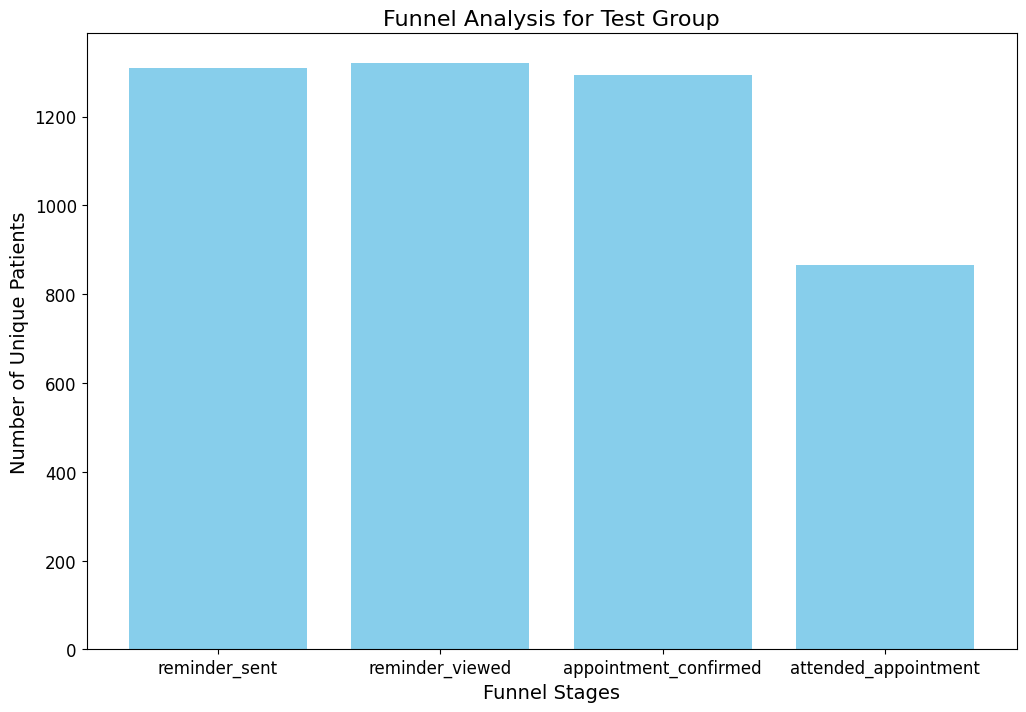

In [34]:
# Load actual dataset
ab_test_data = pd.read_csv('data/ab_test_data.csv')

# Filter for Test group only
test_group = ab_test_data[ab_test_data['group'] == 'Test']

# Define the funnel stages
funnel_stages = ['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment']

# Filter for relevant stages and group by event_name to count unique patient_id's at each stage
funnel_counts = test_group[test_group['event_name'].isin(funnel_stages)]\
    .groupby('event_name')['patient_id'].nunique().reindex(funnel_stages)

# Visualization - Extended size funnel plot
plt.figure(figsize=(12, 8))  # Extended figure size for larger plot
plt.bar(funnel_counts.index, funnel_counts.values, color='skyblue')
plt.xlabel('Funnel Stages', fontsize=14)
plt.ylabel('Number of Unique Patients', fontsize=14)
plt.title('Funnel Analysis for Test Group', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [116]:
# Calculate time difference between reminder_viewed and appointment_confirmed
test_group['event_datetime'] = pd.to_datetime(test_group['event_datetime'])
viewed_confirmed = test_group[test_group['event_name'].isin(['reminder_viewed', 'appointment_confirmed'])]
viewed_confirmed = viewed_confirmed.sort_values(by=['patient_id', 'event_datetime'])
viewed_confirmed['time_diff'] = viewed_confirmed.groupby('patient_id')['event_datetime'].diff()

# Calculate the proportion of patients confirming within 1 hour
within_1_hour = viewed_confirmed[viewed_confirmed['time_diff'].dt.total_seconds() <= 3600]
confirmation_rate_1_hour = within_1_hour['patient_id'].nunique() / test_group['patient_id'].nunique()

print(f"Confirmation Rate within 1 hour: {confirmation_rate_1_hour}")


Confirmation Rate within 1 hour: 0.9742619227857684


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_31139/2594446136.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_group['event_datetime'] = pd.to_datetime(test_group['event_datetime'])


traffic_source
Apple Ads         138
Direct            433
Google Ads        161
Meta Ads          143
Organic Search    414
Referral          446
Name: patient_id, dtype: int64


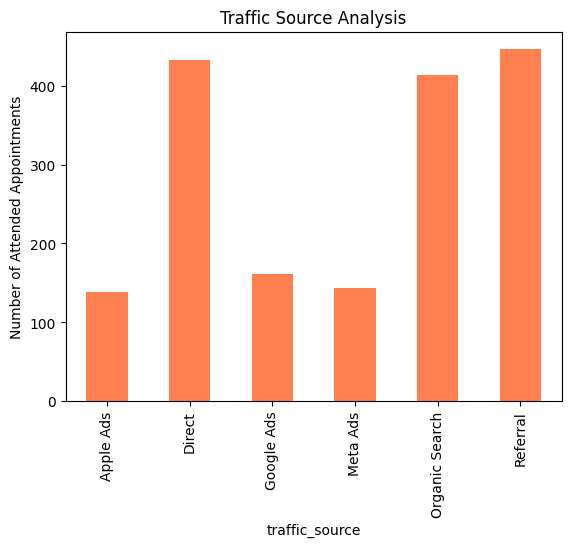

In [118]:
# Merge app_data with appointments_data to analyze traffic sources
merged_data = pd.merge(app_data, appointments_data, on='patient_id')

# Group by traffic source and count attended appointments
traffic_source_analysis = merged_data[merged_data['appointment_status'] == 'Attended'] \
    .groupby('traffic_source')['patient_id'].nunique()

print(traffic_source_analysis)

# Plot the results
traffic_source_analysis.plot(kind='bar', color='coral')
plt.title('Traffic Source Analysis')
plt.ylabel('Number of Attended Appointments')
plt.show()


In [36]:


# Load the data
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merge the two datasets on patient_id using a left join
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Filter the merged data for Test and Control groups
test_group = merged_data[merged_data['group'] == 'Test']
control_group = merged_data[merged_data['group'] == 'Control']

# Count attendance in both groups (attended and not attended)
test_attended = test_group[test_group['appointment_status'] == 'Attended'].shape[0]
test_total = test_group['patient_id'].nunique()

control_attended = control_group[control_group['appointment_status'] == 'Attended'].shape[0]
control_total = control_group['patient_id'].nunique()

# Ensure that totals are non-negative and handle edge cases
test_attended = max(test_attended, 0)
control_attended = max(control_attended, 0)

test_not_attended = max(test_total - test_attended, 0)
control_not_attended = max(control_total - control_attended, 0)

# Create contingency table for Fisher's Exact Test
contingency_table = np.array([[test_attended, test_not_attended],
                              [control_attended, control_not_attended]])

# Check if the table has any negative values before proceeding
if np.any(contingency_table < 0):
    print("Contingency table contains negative values, please verify the data.")
else:
    # Perform Fisher's Exact test
    odds_ratio, p_val = fisher_exact(contingency_table)

    # Calculate the attendance rate for both groups
    attendance_rate_test = (test_attended / test_total) * 100 if test_total > 0 else 0
    attendance_rate_control = (control_attended / control_total) * 100 if control_total > 0 else 0

    # Output results
    print(f"Test Group Attendance Rate: {attendance_rate_test:.2f}%")
    print(f"Control Group Attendance Rate: {attendance_rate_control:.2f}%")
    print(f"Fisher's Exact Test P-value: {p_val}")


NameError: name 'fisher_exact' is not defined

In [ ]:
import pandas as pd
from scipy.stats import fisher_exact
import numpy as np

# Load the data
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merge the two datasets on patient_id using a left join
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Filter the merged data for Test and Control groups
test_group = merged_data[merged_data['group'] == 'Test']
control_group = merged_data[merged_data['group'] == 'Control']

# Count attendance in both groups (attended and not attended)
test_attended = test_group[test_group['appointment_status'] == 'Attended'].shape[0]
test_total = test_group['patient_id'].nunique()

control_attended = control_group[control_group['appointment_status'] == 'Attended'].shape[0]
control_total = control_group['patient_id'].nunique()

# Ensure that totals are non-negative and handle edge cases
test_attended = max(test_attended, 0)
control_attended = max(control_attended, 0)

test_not_attended = max(test_total - test_attended, 0)
control_not_attended = max(control_total - control_attended, 0)

# Create contingency table for Fisher's Exact Test
contingency_table = np.array([[test_attended, test_not_attended],
                              [control_attended, control_not_attended]])

# Check if the table has any negative values before proceeding
if np.any(contingency_table < 0):
    print("Contingency table contains negative values, please verify the data.")
else:
    # Perform Fisher's Exact test
    odds_ratio, p_val = fisher_exact(contingency_table)

    # Calculate the attendance rate for both groups
    attendance_rate_test = (test_attended / test_total) * 100 if test_total > 0 else 0
    attendance_rate_control = (control_attended / control_total) * 100 if control_total > 0 else 0

    # Output results
    print(f"Test Group Attendance Rate: {attendance_rate_test:.2f}%")
    print(f"Control Group Attendance Rate: {attendance_rate_control:.2f}%")
    print(f"Fisher's Exact Test P-value: {p_val}")


Test Group Attendance Rate: 261.70%
Control Group Attendance Rate: 100.00%
Fisher's Exact Test P-value: 1.0


In [131]:
# Load the data
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Merge the two datasets on patient_id using a left join
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Filter the merged data for Test and Control groups
test_group = merged_data[merged_data['group'] == 'Test']
control_group = merged_data[merged_data['group'] == 'Control']

# Count unique patients who attended in both groups
test_attended = test_group[test_group['appointment_status'] == 'Attended']['patient_id'].nunique()
test_total = test_group['patient_id'].nunique()

control_attended = control_group[control_group['appointment_status'] == 'Attended']['patient_id'].nunique()
control_total = control_group['patient_id'].nunique()

# Calculate not attended (total - attended)
test_not_attended = test_total - test_attended
control_not_attended = control_total - control_attended

# Create contingency table for Fisher's Exact Test
contingency_table = np.array([[test_attended, test_not_attended],
                              [control_attended, control_not_attended]])

# Check if the table has any negative values before proceeding
if np.any(contingency_table < 0):
    print("Contingency table contains negative values, please verify the data.")
else:
    # Perform Fisher's Exact test
    odds_ratio, p_val = fisher_exact(contingency_table)

    # Calculate the attendance rate for both groups
    attendance_rate_test = (test_attended / test_total) * 100 if test_total > 0 else 0
    attendance_rate_control = (control_attended / control_total) * 100 if control_total > 0 else 0

    # Output results
    print(f"Test Group Attendance Rate: {attendance_rate_test:.2f}%")
    print(f"Control Group Attendance Rate: {attendance_rate_control:.2f}%")
    print(f"Fisher's Exact Test P-value: {p_val}")


Test Group Attendance Rate: 65.56%
Control Group Attendance Rate: 100.00%
Fisher's Exact Test P-value: 3.385311745552254e-117


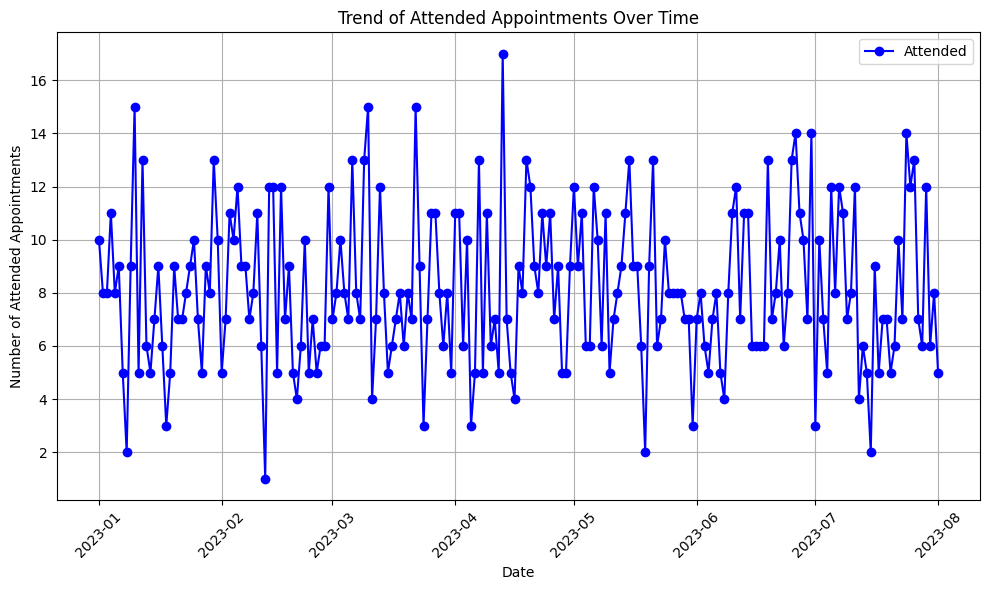

In [136]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the appointments data
appointments_data = pd.read_csv('data/appointments_data.csv')

# Convert appointment_date to datetime format
appointments_data['appointment_date'] = pd.to_datetime(appointments_data['appointment_date'])

# Calculate the trend of attended appointments over time
attended_trend = appointments_data[appointments_data['appointment_status'] == 'Attended']\
    .groupby('appointment_date').size()

# Plot the line chart for attended appointments over time
plt.figure(figsize=(10, 6))
plt.plot(attended_trend.index, attended_trend.values, marker='o', linestyle='-', color='blue', label='Attended')
plt.xlabel('Date')
plt.ylabel('Number of Attended Appointments')
plt.title('Trend of Attended Appointments Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()



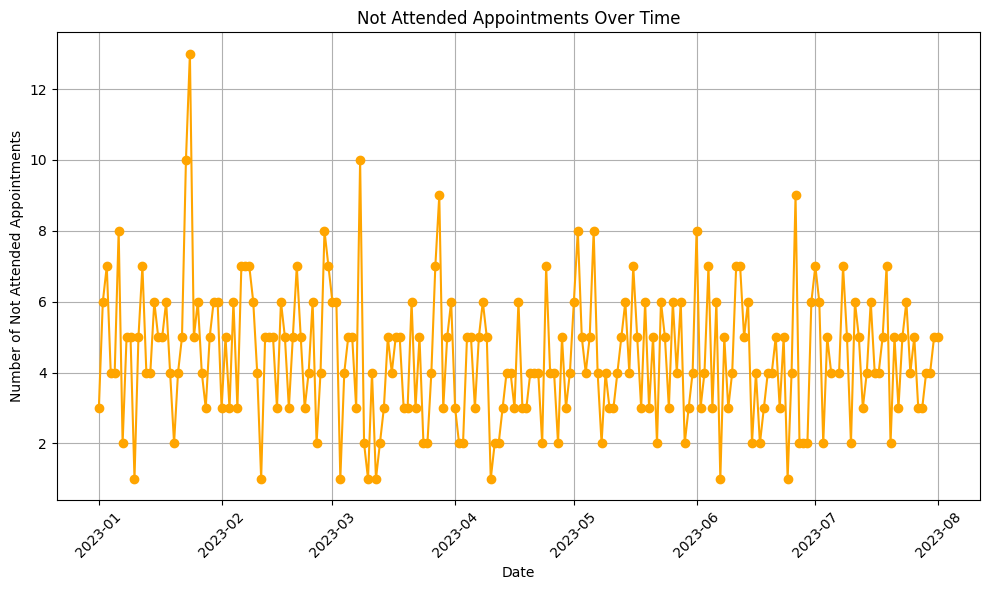

In [135]:
# Let's calculate the non-attendance over the entire time period and fix the chart to display all dates

# First, calculate the number of not attended appointments over time
appointments_data['appointment_date'] = pd.to_datetime(appointments_data['appointment_date'])

# Filter for not attended appointments
not_attended_data = appointments_data[appointments_data['appointment_status'] != 'Attended']

# Group by appointment date to count not attended appointments
not_attended_over_time = not_attended_data.groupby('appointment_date').size()

# Plotting the line chart for non-attended appointments over time
plt.figure(figsize=(10, 6))
plt.plot(not_attended_over_time.index, not_attended_over_time.values, label="Not Attended", color='orange', marker='o')
plt.title('Not Attended Appointments Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Not Attended Appointments')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()


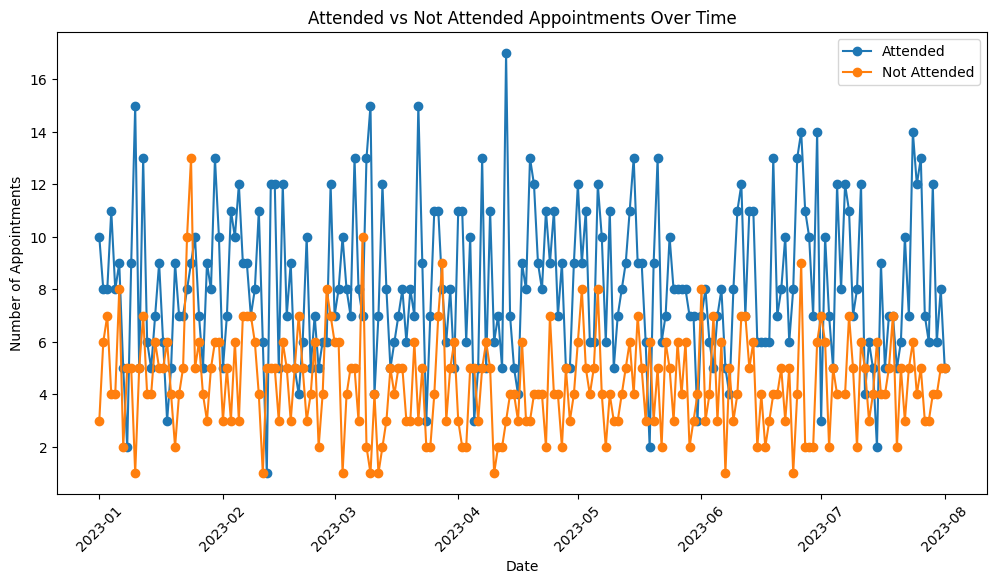

In [137]:
# Grouping by appointment_date and counting attended and not attended appointments
attended_by_date = appointments_data[appointments_data['appointment_status'] == 'Attended'].groupby('appointment_date').size()
not_attended_by_date = appointments_data[appointments_data['appointment_status'] != 'Attended'].groupby('appointment_date').size()

# Creating a chart with both attended and not attended counts over time
plt.figure(figsize=(12, 6))

# Plot for attended appointments
plt.plot(attended_by_date.index, attended_by_date, label='Attended', marker='o')

# Plot for not attended appointments
plt.plot(not_attended_by_date.index, not_attended_by_date, label='Not Attended', marker='o')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Number of Appointments')
plt.title('Attended vs Not Attended Appointments Over Time')
plt.xticks(rotation=45)
plt.legend()

# Display the plot
plt.show()


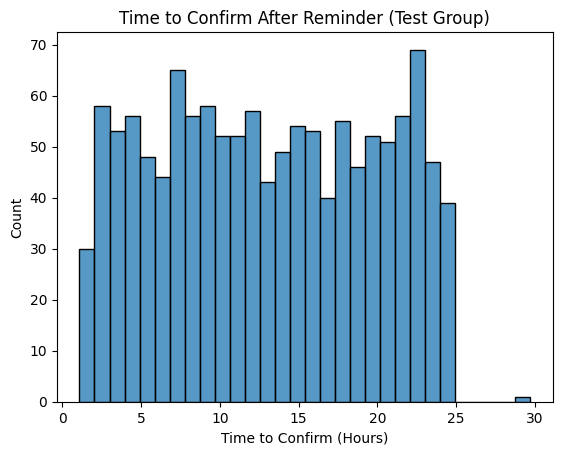

In [142]:
# Merge A/B Test Data with Appointments Data
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Ensure 'event_datetime' is in datetime format
merged_data['event_datetime'] = pd.to_datetime(merged_data['event_datetime'])
merged_data['appointment_date'] = pd.to_datetime(merged_data['appointment_date'])

# Filter Test group data
test_group = merged_data[merged_data['group'] == 'Test']

# Identify the reminder_sent and appointment_confirmed events for each patient
reminder_sent = test_group[test_group['event_name'] == 'reminder_sent']
appointment_confirmed = test_group[test_group['event_name'] == 'appointment_confirmed']

# Merge to calculate time difference between reminder_sent and appointment_confirmed
reminder_confirmed = pd.merge(reminder_sent[['patient_id', 'event_datetime']],
                              appointment_confirmed[['patient_id', 'event_datetime']],
                              on='patient_id',
                              suffixes=('_reminder_sent', '_appointment_confirmed'))

# Calculate the time difference in hours
reminder_confirmed['time_to_confirm'] = (reminder_confirmed['event_datetime_appointment_confirmed'] - 
                                         reminder_confirmed['event_datetime_reminder_sent']).dt.total_seconds() / 3600

# Plot the distribution of time to confirm after reminder
sns.histplot(reminder_confirmed['time_to_confirm'], bins=30)
plt.title('Time to Confirm After Reminder (Test Group)')
plt.xlabel('Time to Confirm (Hours)')
plt.show()

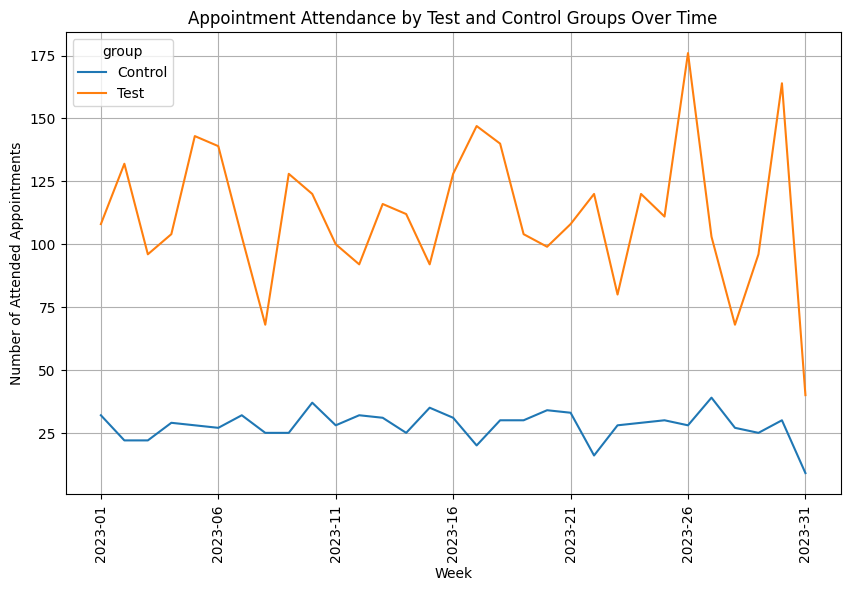

In [144]:
# Ensure 'appointment_date' is in datetime format
merged_data['appointment_date'] = pd.to_datetime(merged_data['appointment_date'])

# Create a 'year-week' column to group by week
merged_data['year_week'] = merged_data['appointment_date'].dt.strftime('%Y-%U')

# Count attended appointments by group over time (weekly)
attendance_over_time = merged_data[merged_data['appointment_status'] == 'Attended'].groupby(['year_week', 'group'])['patient_id'].count().unstack()

# Plot the attendance rate over time for both groups
attendance_over_time.plot(figsize=(10, 6))
plt.title('Appointment Attendance by Test and Control Groups Over Time')
plt.xlabel('Week')
plt.ylabel('Number of Attended Appointments')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


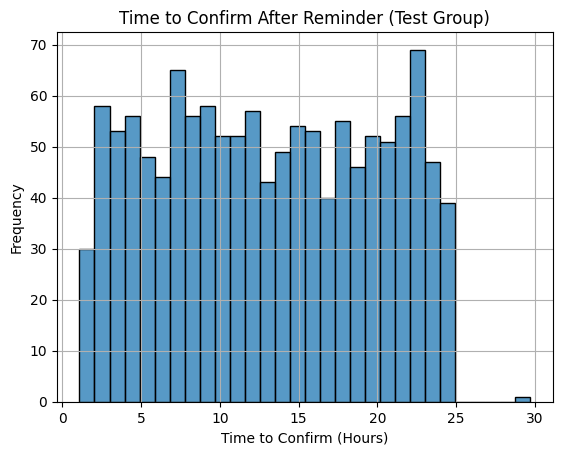

In [145]:
# Ensure 'event_datetime' is in datetime format
merged_data['event_datetime'] = pd.to_datetime(merged_data['event_datetime'])

# Filter for Test group and necessary events
test_group = merged_data[merged_data['group'] == 'Test']
reminder_sent = test_group[test_group['event_name'] == 'reminder_sent']
appointment_confirmed = test_group[test_group['event_name'] == 'appointment_confirmed']

# Merge on patient_id to calculate time between reminder_sent and appointment_confirmed
reminder_confirmed = pd.merge(reminder_sent[['patient_id', 'event_datetime']],
                              appointment_confirmed[['patient_id', 'event_datetime']],
                              on='patient_id',
                              suffixes=('_reminder_sent', '_appointment_confirmed'))

# Calculate the time difference in hours
reminder_confirmed['time_to_confirm'] = (reminder_confirmed['event_datetime_appointment_confirmed'] - 
                                         reminder_confirmed['event_datetime_reminder_sent']).dt.total_seconds() / 3600

# Plot the distribution of confirmation times
sns.histplot(reminder_confirmed['time_to_confirm'], bins=30)
plt.title('Time to Confirm After Reminder (Test Group)')
plt.xlabel('Time to Confirm (Hours)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


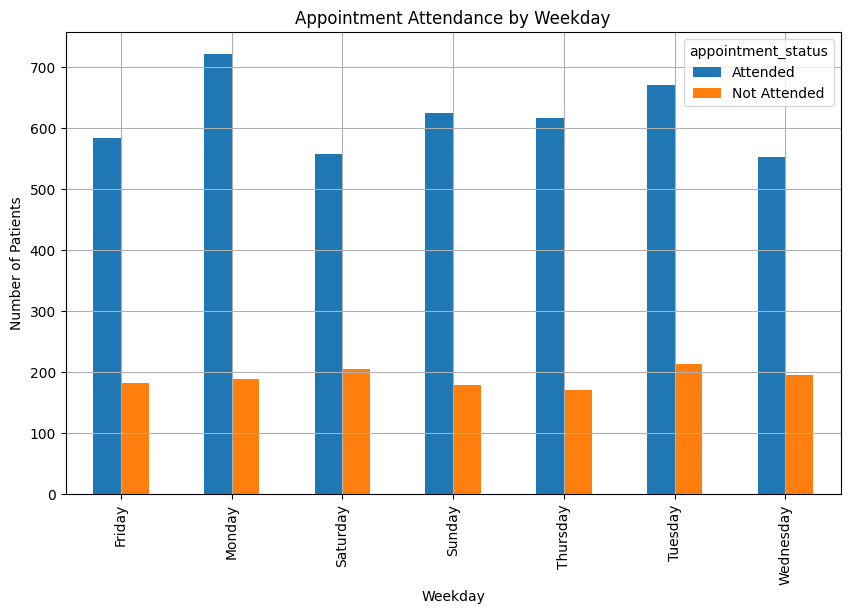

In [146]:
# Extract the weekday from the appointment date
merged_data['weekday'] = merged_data['appointment_date'].dt.day_name()

# Group by weekday and appointment status
attendance_by_weekday = merged_data.groupby(['weekday', 'appointment_status'])['patient_id'].count().unstack()

# Plot attendance vs. non-attendance by weekday
attendance_by_weekday.plot(kind='bar', figsize=(10, 6))
plt.title('Appointment Attendance by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.show()


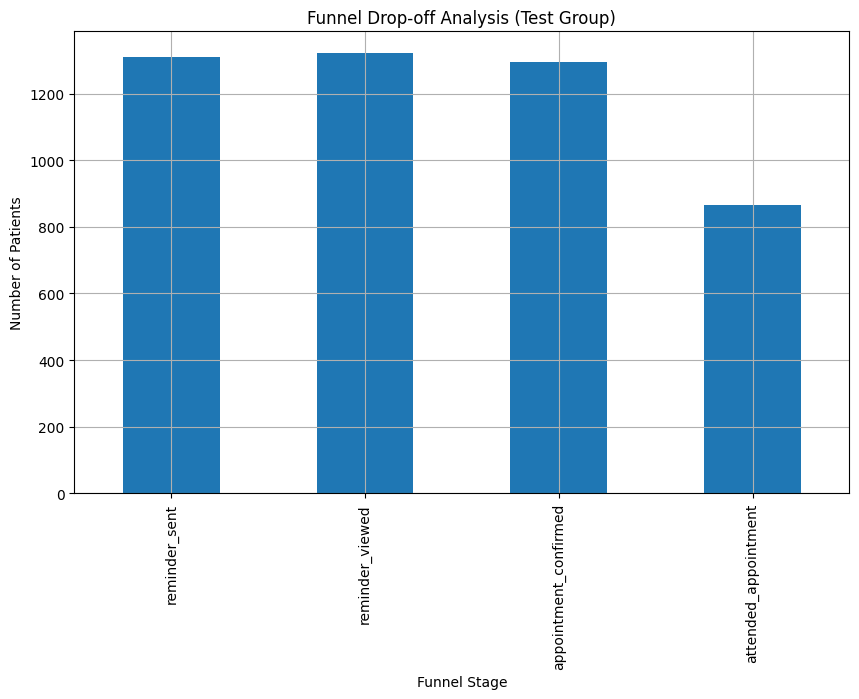

In [147]:
# Define funnel stages
funnel_stages = ['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment']

# Filter Test group data for funnel stages
funnel_data = test_group[test_group['event_name'].isin(funnel_stages)]

# Group by event name to count unique patient_id at each funnel stage
funnel_counts = funnel_data.groupby('event_name')['patient_id'].nunique().reindex(funnel_stages)

# Plot the funnel
funnel_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Funnel Drop-off Analysis (Test Group)')
plt.xlabel('Funnel Stage')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.show()


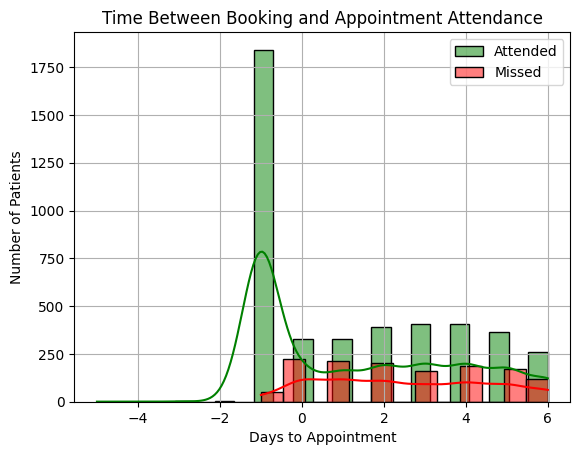

In [148]:
# Calculate the difference between appointment_date and event_datetime for appointment booking
merged_data['time_to_appointment'] = (merged_data['appointment_date'] - merged_data['event_datetime']).dt.days

# Filter for attended and missed appointments
attended_data = merged_data[merged_data['appointment_status'] == 'Attended']
missed_data = merged_data[merged_data['appointment_status'] != 'Attended']

# Plot the time to appointment for both attended and missed appointments
sns.histplot(attended_data['time_to_appointment'], color='green', label='Attended', kde=True)
sns.histplot(missed_data['time_to_appointment'], color='red', label='Missed', kde=True)
plt.title('Time Between Booking and Appointment Attendance')
plt.xlabel('Days to Appointment')
plt.ylabel('Number of Patients')
plt.legend()
plt.grid(True)
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_31139/1088639237.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attendance_by_age_gender = merged_data.groupby(['age_group', 'gender', 'appointment_status'])['patient_id'].count().unstack()


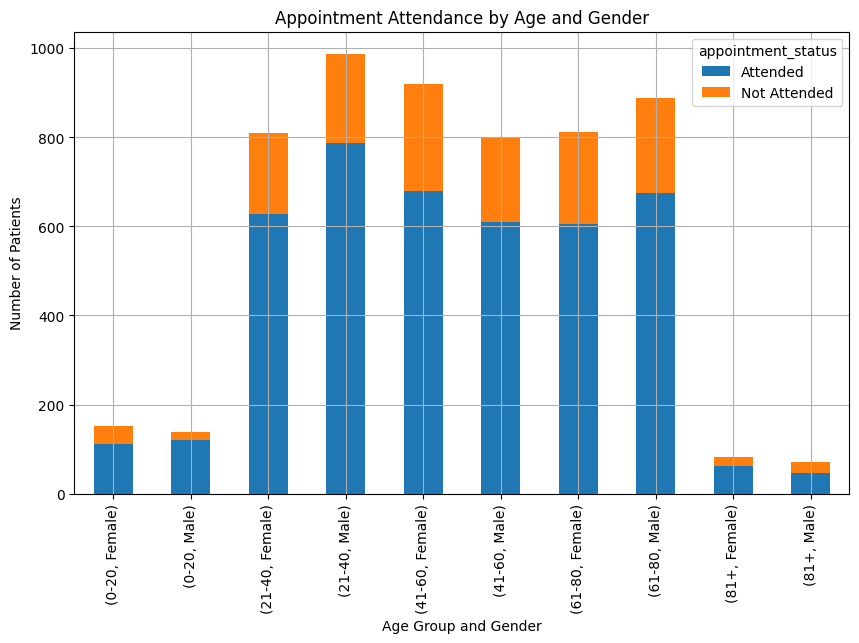

In [149]:
# Create age groups
merged_data['age_group'] = pd.cut(merged_data['age'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '21-40', '41-60', '61-80', '81+'])

# Group by age group, gender, and appointment status
attendance_by_age_gender = merged_data.groupby(['age_group', 'gender', 'appointment_status'])['patient_id'].count().unstack()

# Plot the attendance rates by age and gender
attendance_by_age_gender.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Appointment Attendance by Age and Gender')
plt.xlabel('Age Group and Gender')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.show()


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_31139/1347060155.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attendance_by_age_gender = merged_data.groupby(['age_group', 'gender', 'appointment_status'])['patient_id'].count().unstack()


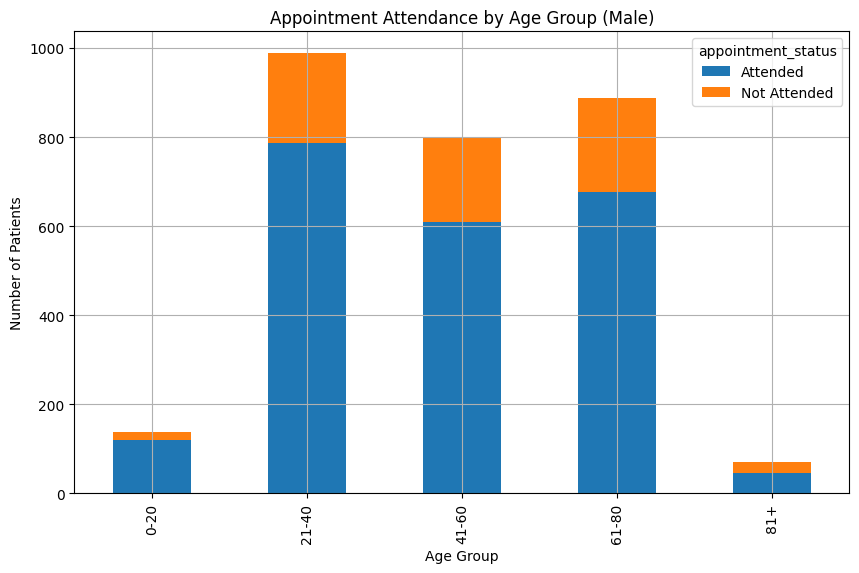

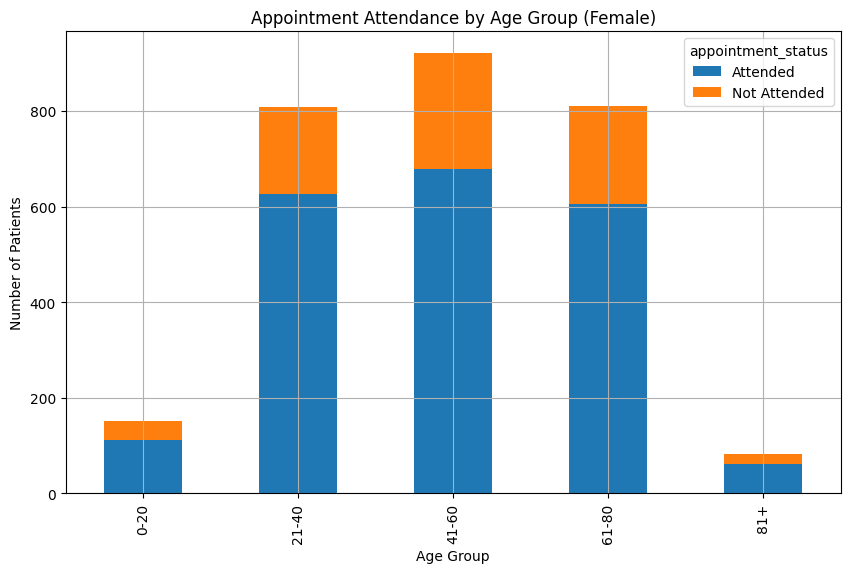

In [154]:
# Plotting separate charts for male and female attendance rates by age group

# Group the data by age group, gender, and appointment status
attendance_by_age_gender = merged_data.groupby(['age_group', 'gender', 'appointment_status'])['patient_id'].count().unstack()

# Separate the data by gender
attendance_by_age_male = attendance_by_age_gender.xs('Male', level='gender')
attendance_by_age_female = attendance_by_age_gender.xs('Female', level='gender')

# Plot for Male
attendance_by_age_male.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Appointment Attendance by Age Group (Male)')
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.show()

# Plot for Female
attendance_by_age_female.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Appointment Attendance by Age Group (Female)')
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.show()


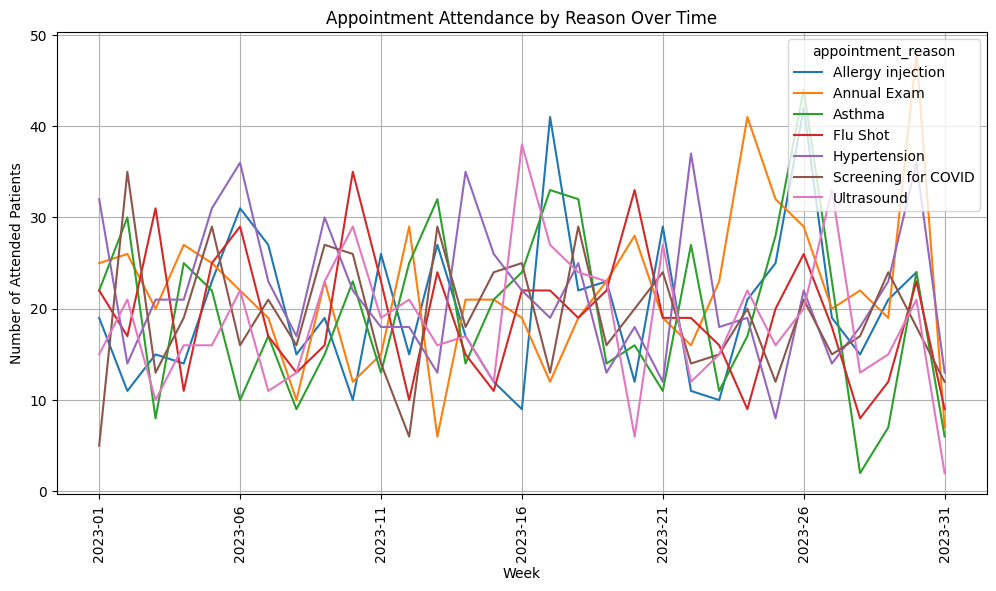

In [150]:
# Group by appointment reason and week
attendance_by_reason = merged_data.groupby(['year_week', 'appointment_reason', 'appointment_status'])['patient_id'].count().unstack()

# Plot attendance over time for different reasons
attendance_by_reason['Attended'].unstack().plot(figsize=(12, 6))
plt.title('Appointment Attendance by Reason Over Time')
plt.xlabel('Week')
plt.ylabel('Number of Attended Patients')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


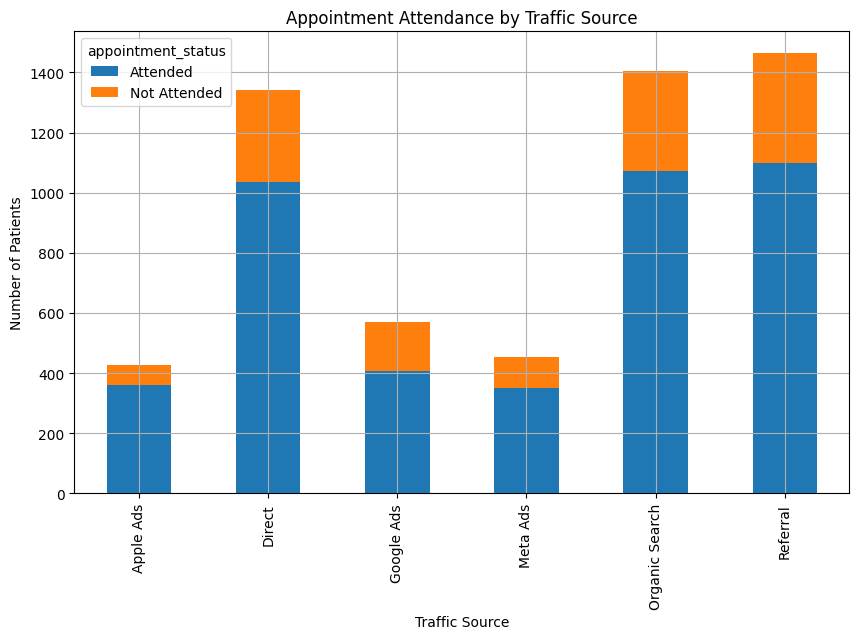

In [152]:
# Group by traffic_source and appointment status
traffic_source_analysis = merged_data.groupby(['traffic_source', 'appointment_status'])['patient_id'].count().unstack()

# Plot the attendance rates by traffic source
traffic_source_analysis.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Appointment Attendance by Traffic Source')
plt.xlabel('Traffic Source')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.show()


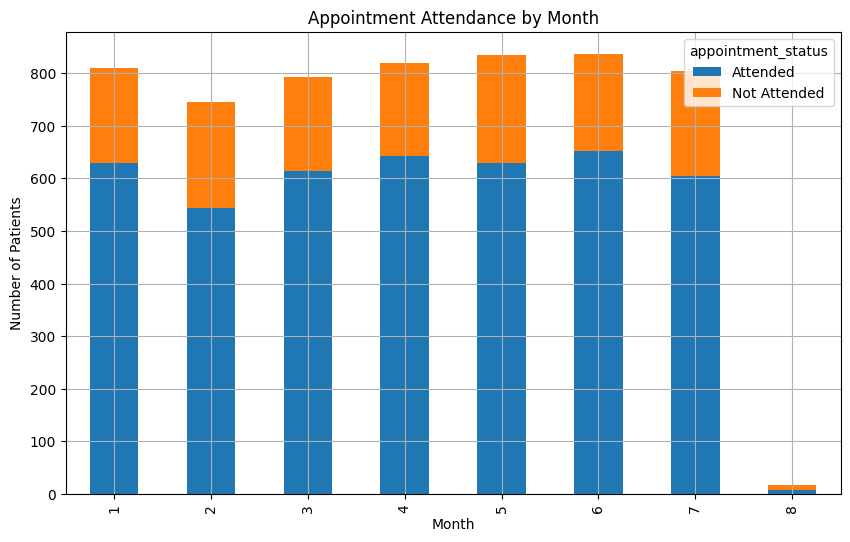

In [153]:
# Extract month from appointment_date
merged_data['month'] = merged_data['appointment_date'].dt.month

# Group by month and appointment status
attendance_by_month = merged_data.groupby(['month', 'appointment_status'])['patient_id'].count().unstack()

# Plot the attendance rates by month
attendance_by_month.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Appointment Attendance by Month')
plt.xlabel('Month')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.show()


In [157]:
# Reload the necessary data for merging
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')
app_data['device'] = app_data['device'].str.lower()

# Group the devices into Android and iOS
app_data['device_group'] = app_data['device'].apply(lambda x: 'android' if 'android' in x else 'ios' if 'ios' in x else 'other')

# Merge the two datasets on patient_id using a left join
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')

# Now, let's merge the app_data with the merged_data to link the appointment and A/B testing information
merged_app_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Group by device type and calculate the attendance status (attended vs not attended)
device_drop_off = merged_app_data.groupby(['device_group', 'appointment_status'])['patient_id'].count().unstack()

device_drop_off

appointment_status,Attended,Not Attended
device_group,,
android,2024,632
ios,2302,702


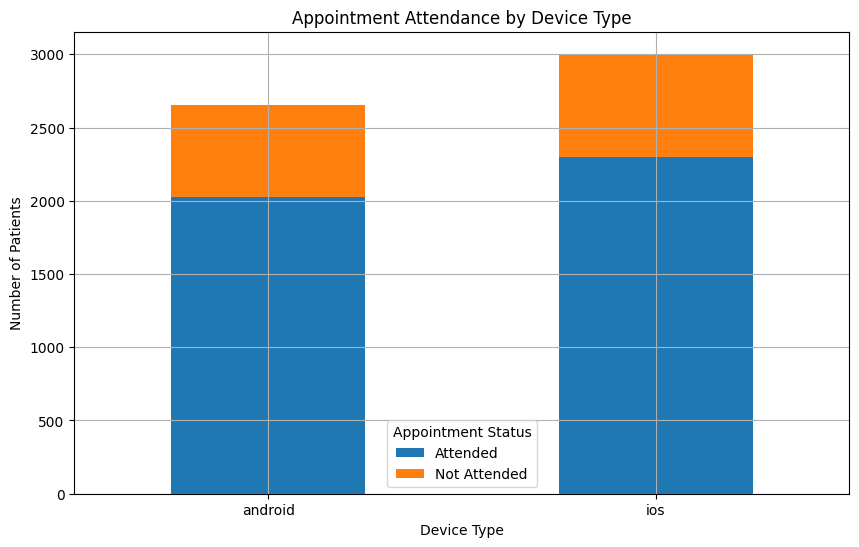

In [158]:

# Load datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Convert devices to lowercase and group into Android/iOS/Other
app_data['device'] = app_data['device'].str.lower()
app_data['device_group'] = app_data['device'].apply(lambda x: 'android' if 'android' in x else 'ios' if 'ios' in x else 'other')

# Merge datasets
merged_data = pd.merge(ab_test_data, appointments_data, on='patient_id', how='left')
merged_app_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Group by device type and appointment status
device_drop_off = merged_app_data.groupby(['device_group', 'appointment_status'])['patient_id'].count().unstack()

# Plotting the result
device_drop_off.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Appointment Attendance by Device Type')
plt.xlabel('Device Type')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.legend(title='Appointment Status')
plt.grid(True)
plt.show()


In [151]:
# Calculate the difference in days between reminder viewed and appointment confirmed
reminder_viewed = test_group[test_group['event_name'] == 'reminder_viewed']
appointment_confirmed = test_group[test_group['event_name'] == 'appointment_confirmed']

# Merge and calculate time difference
reminder_confirmed = pd.merge(reminder_viewed[['patient_id', 'event_datetime']],
                              appointment_confirmed[['patient_id', 'event_datetime']],
                              on='patient_id',
                              suffixes=('_reminder_viewed', '_appointment_confirmed'))

# Calculate the difference in days
reminder_confirmed['days_to_confirm'] = (reminder_confirmed['event_datetime_appointment_confirmed'] - 
                                         reminder_confirmed['event_datetime_reminder_viewed']).dt.days

# Calculate how many confirmed on the same day
same_day_confirmations = reminder_confirmed[reminder_confirmed['days_to_confirm'] == 0].shape[0]
total_confirmations = reminder_confirmed.shape[0]

# Output percentage of same-day confirmations
same_day_percentage = (same_day_confirmations / total_confirmations) * 100
print(f"Same-day Confirmations: {same_day_percentage:.2f}%")


Same-day Confirmations: 99.92%


In [99]:
# Load datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')

# Filter for Test group only
test_group = ab_test_data[ab_test_data['group'] == 'Test']

# Convert event_datetime to datetime format
test_group['event_datetime'] = pd.to_datetime(test_group['event_datetime'])

# Pivot the Test group data to have event types as columns
pivoted_test = test_group.pivot(index='patient_id', columns='event_name', values='event_datetime')

# Calculate time difference between reminder_sent and reminder_viewed
pivoted_test['response_time_to_view'] = (pivoted_test['reminder_viewed'] - pivoted_test['reminder_sent']).dt.total_seconds() / 3600

# Calculate time difference between reminder_sent and appointment_confirmed
pivoted_test['response_time_to_confirm'] = (pivoted_test['appointment_confirmed'] - pivoted_test['reminder_sent']).dt.total_seconds() / 3600

# Filter out patients with missing times
response_times = pivoted_test[['response_time_to_view', 'response_time_to_confirm']].dropna()

# Output the average response times
average_time_to_view = response_times['response_time_to_view'].mean()
average_time_to_confirm = response_times['response_time_to_confirm'].mean()

print(f"Average Time to View Reminder: {average_time_to_view:.2f} hours")
print(f"Average Time to Confirm Appointment: {average_time_to_confirm:.2f} hours")

Average Time to View Reminder: 12.52 hours
Average Time to Confirm Appointment: 13.06 hours


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_31139/2154243314.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_group['event_datetime'] = pd.to_datetime(test_group['event_datetime'])


In [89]:
# Create columns for day of the week and hour of the day
pivoted_test['reminder_sent_day'] = pivoted_test['reminder_sent'].dt.day_name()
pivoted_test['reminder_sent_hour'] = pivoted_test['reminder_sent'].dt.hour

pivoted_test['appointment_confirmed_day'] = pivoted_test['appointment_confirmed'].dt.day_name()
pivoted_test['appointment_confirmed_hour'] = pivoted_test['appointment_confirmed'].dt.hour

# Analyze the response time by day of the week (use a list for columns)
daywise_response = pivoted_test.groupby('reminder_sent_day')[['response_time_to_view', 'response_time_to_confirm']].mean()

# Analyze the response time by hour of the day (use a list for columns)
hourwise_response = pivoted_test.groupby('reminder_sent_hour')[['response_time_to_view', 'response_time_to_confirm']].mean()

print(f"\nResponse Time by Day of the Week:\n{daywise_response}")
print(f"\nResponse Time by Hour of the Day:\n{hourwise_response}")



Response Time by Day of the Week:
event_name         response_time_to_view  response_time_to_confirm
reminder_sent_day                                                 
Friday                         12.776502                 13.377693
Monday                         12.412976                 12.878694
Saturday                       11.208312                 11.605397
Sunday                         12.565004                 13.010241
Thursday                       13.419092                 13.992461
Tuesday                        12.771843                 13.340025
Wednesday                      12.429656                 13.070764

Response Time by Hour of the Day:
event_name          response_time_to_view  response_time_to_confirm
reminder_sent_hour                                                 
0.0                             10.875803                 11.377088
1.0                             12.727978                 13.486480
2.0                             10.662875              

/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_31139/3676263062.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  funnel_counts = {stage: df[df['event_name'] == stage].groupby('age_group')['patient_id'].nunique() for stage in funnel_stages}


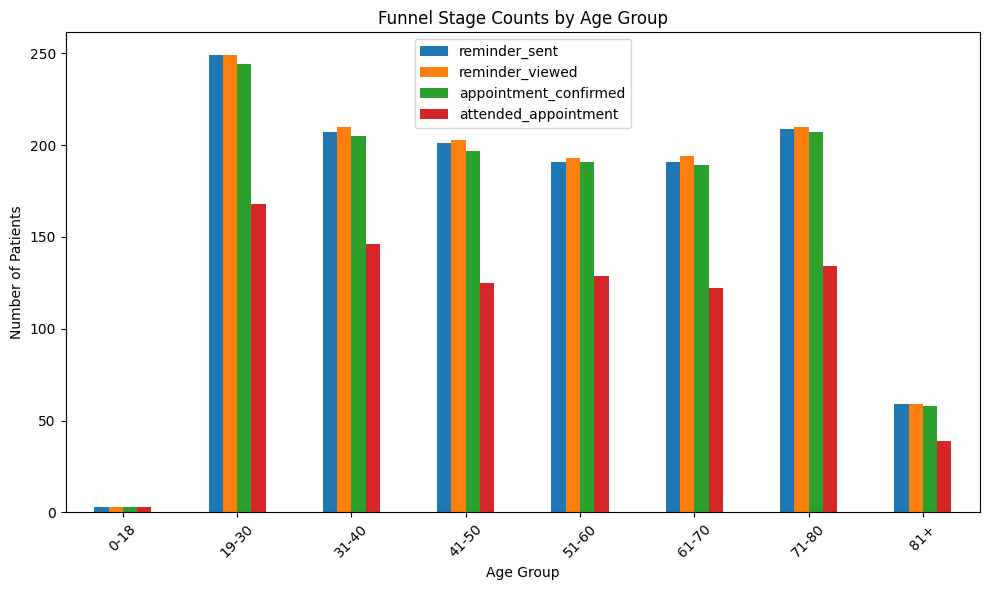

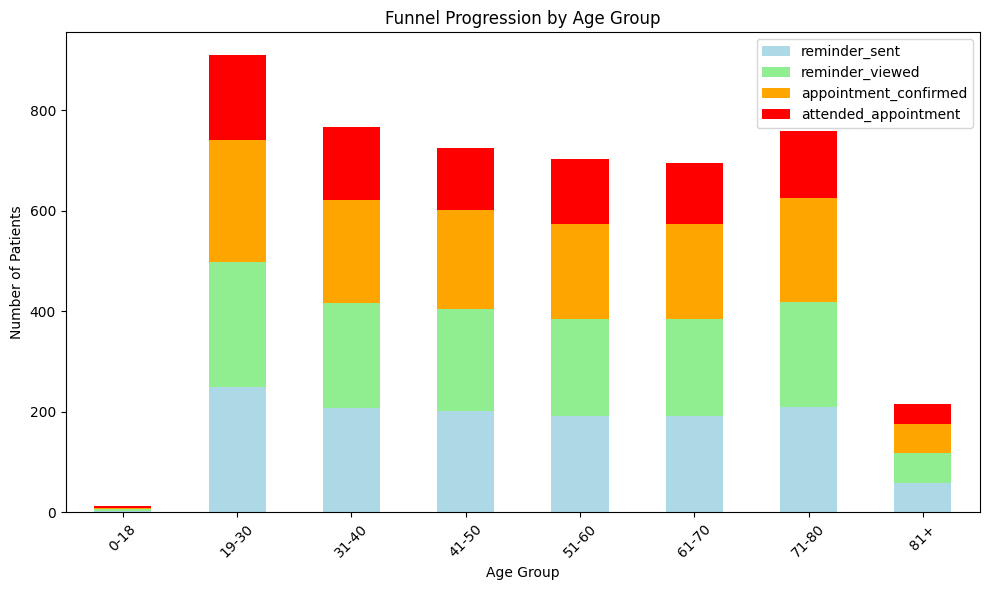

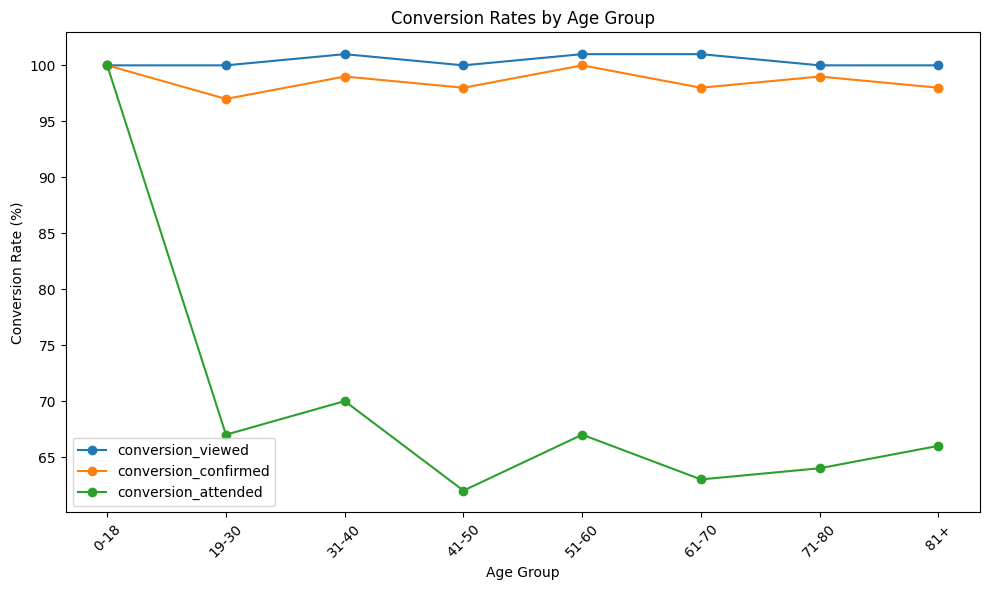

In [132]:
# Load dataset (assuming ab_appointments_merged is already loaded as a DataFrame)
df = ab_appointments_merged.copy()
df = df[df['group'] == 'Test']
# Define age groups
bins = [0, 18, 30, 40, 50, 60, 70, 80, 100]
labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Step 1: Analyze funnel stages by age group
funnel_stages = ['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment']

# Create a dictionary to store funnel counts for each stage
funnel_counts = {stage: df[df['event_name'] == stage].groupby('age_group')['patient_id'].nunique() for stage in funnel_stages}

# Convert the funnel_counts dictionary to a DataFrame 
funnel_df = pd.DataFrame(funnel_counts).fillna(0)  
# Fill missing values with 0

# Step 2: Calculate conversion rates for each age group
funnel_df['conversion_viewed'] = (funnel_df['reminder_viewed'] / funnel_df['reminder_sent']) * 100
funnel_df['conversion_confirmed'] = (funnel_df['appointment_confirmed'] / funnel_df['reminder_sent']) * 100
funnel_df['conversion_attended'] = (funnel_df['attended_appointment'] / funnel_df['reminder_sent']) * 100

# Step 3: Display the funnel data for each age group
funnel_df = funnel_df[['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment', 'conversion_viewed', 'conversion_confirmed', 'conversion_attended']]
funnel_df = funnel_df.astype(int, errors='ignore')  # Convert counts to integer for cleaner display

# Bar chart for Funnel Stage Counts
funnel_stages = ['reminder_sent', 'reminder_viewed', 'appointment_confirmed', 'attended_appointment']
funnel_df[funnel_stages].plot(kind='bar', figsize=(10, 6))
plt.title('Funnel Stage Counts by Age Group')
plt.ylabel('Number of Patients')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Stacked bar chart for Funnel Progression
funnel_df[funnel_stages].plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightblue', 'lightgreen', 'orange', 'red'])
plt.title('Funnel Progression by Age Group')
plt.ylabel('Number of Patients')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Line chart for Conversion Rates
conversion_columns = ['conversion_viewed', 'conversion_confirmed', 'conversion_attended']
funnel_df[conversion_columns].plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Conversion Rates by Age Group')
plt.ylabel('Conversion Rate (%)')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
